# Setup

In [ ]:
#Check directory
#!pwd

In [ ]:
#Change directory
#%cd /Users/georgesmith/Desktop/RTP/DONOR DATA ANALYSIS

In [1]:
#Import necessary packages:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import datetime
from datetime import date
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display
import sys
#Install pingouin package into this jupyter kernal
#!{sys.executable} -m pip install pingouin
import pingouin as pg #this throws the warning message
#!{sys.executable} -m pip install --upgrade statsmodels
import pickle
import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls
#import sys
#!{sys.executable} -m pip install pandas_profiling
#import pandas_profiling

%matplotlib inline

/Users/georgesmith/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.6.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
#Read in donation data:
input_cols = ['donation_id',
 'donation_name',
 'donation_record_type',
 'amount',
 'close_date',
 'account_name',
 'account_id',
 'account_record_type',
 'contact_id',
 'pledge_amount',
 'fund',
 'payment_type',
 'fiscal_quarter',
 'fiscal_year',
 'type',
 'frequency',
 'donation_matched',
 'amount_matched',
 'matching_close_date',
 'first_donation_date',
 'last_donation_amount',
 'last_donation_date',
 'lifetime_donation_count',
 'lifetime_donation_total_amount',
 'lifetime_order_count',
 'lifetime_single_ticket_purchase_total',
 'lifetime_subscription_purchase_total',
 'do_not_mail',
 'email_opt_out',
 'account_created_date',
 'contact_email',
 'payment_schedule',
 'stage',
 'contact_phone',
 'account_phone',
 'amount_due',
 'amount_paid',
 'anonymous',
 'card_type',
 'dedication_type',
 'donation_origin',
 'donor_name',
 'donor_last_first',
 'amount_donated_last_365_days',
 'amount_donated_last_fiscal_year',
 'amount_donated_this_fiscal_year',
 'description',
 'group_sales_total',
 'ticket_order_id',
 'total_amount',
 'transaction_id',
 'last_transaction_id',
 'order_count_last_#_days',
 'mailing_street',
 'mailing_city',
 'mailing_state',
 'mailing_zip']
raw_donations = pd.read_csv('/Users/georgesmith/Desktop/RTP/DONOR DATA ANALYSIS/donations_by_acct_contact_July_2014_July_21_2020.csv', header=0, names=input_cols)

In [3]:
#Remove columns necessary to anonymize each record
identifying_cols = ['donation_name', 'account_name', 'donation_matched', 'contact_email', 'contact_phone', 'account_phone', 'donor_name', 'donor_last_first', 'mailing_street']
donations = raw_donations.drop(identifying_cols, axis=1, inplace=False)
donations.head()

,donation_id,donation_record_type,amount,close_date,account_id,account_record_type,contact_id,pledge_amount,fund,payment_type,...,description,group_sales_total,ticket_order_id,total_amount,transaction_id,last_transaction_id,order_count_last_#_days,mailing_city,mailing_state,mailing_zip
0,0063600000h6uBQ,Pledge Payment,1000.0,6/30/18,0013600000VKQlu,Household,0033600000NZkdZ,NaN,25th Anniversary Campaign Fund,Check,...,NaN,0.0,NaN,1000.0,NaN,NaN,7.0,Richmond,VA,23230-4411
1,0063600000GVWrS,Pledge Payment,1000.0,12/28/16,0013600000VKQlu,Household,0033600000NZkdZ,NaN,25th Anniversary Campaign Fund,Check,...,NaN,0.0,NaN,1000.0,NaN,NaN,7.0,Richmond,VA,23230-4411
2,0063p00000tn3Rf,Pledge Payment,20000.0,12/13/19,0013600000VKRZd,Individual,0033600000NZkkJ,NaN,25th Anniversary Campaign Fund,Credit Card,...,NaN,0.0,NaN,20000.0,111844.0,00D36000000j6TAEAY~0063p00000tn3RfAAI~00000011...,5.0,RICHMOND,VA,23229
3,0063600000WKiZk,Pledge Payment,20000.0,12/22/17,0013600000VKRZd,Individual,0033600000NZkkJ,NaN,25th Anniversary Fund,Check,...,NaN,0.0,NaN,20000.0,NaN,NaN,5.0,RICHMOND,VA,23229
4,0063600000GVNJz,Pledge Payment,20000.0,12/30/16,0013600000VKRZd,Individual,0033600000NZkkJ,NaN,25th Anniversary Campaign Fund,Check,...,NaN,0.0,NaN,20000.0,NaN,NaN,5.0,RICHMOND,VA,23229


In [4]:
donations.shape

(4193, 48)

In [5]:
#Get variable dataypes and non-null counts:
donations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   donation_id                            4193 non-null   object 
 1   donation_record_type                   4193 non-null   object 
 2   amount                                 4146 non-null   float64
 3   close_date                             4193 non-null   object 
 4   account_id                             4191 non-null   object 
 5   account_record_type                    4191 non-null   object 
 6   contact_id                             4193 non-null   object 
 7   pledge_amount                          43 non-null     float64
 8   fund                                   2486 non-null   object 
 9   payment_type                           4036 non-null   object 
 10  fiscal_quarter                         4193 non-null   object 
 11  fisc

In [6]:
def col_dtype_conversions(df, col_list1, new_dtype1, col_list2, new_dtype2):
    """
    Converts columns in col_list1 to datatype specified in new_dtype1
    and converts those in col_list2 to datatype specified in new_dtype2

    Params
    ------
    df : pandas.DataFrame
        dataframe with columns in both col_lists
    col_list1 : list
        list of column names to be converted to dtype specified by new_dtype1
    new_dtype1 : str (must put in quotes)
        data type to which columns in col_list1 will be converted
    col_list2 : list
        list of column names to be converted to dtype specified by new_dtype2
    new_dtype2 : str (must put in quotes)
        data type to which columns in col_list2 will be converted

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns, some of which are now cast as
        the specified data types
    """
    for col1 in col_list1:
        df[col1] = df[col1].astype(new_dtype1)
        for col2 in col_list2:
            df[col2] = df[col2].astype(new_dtype2)
    return

In [7]:
col1 = ['fiscal_year', 'transaction_id']
col2 = ['close_date', 'first_donation_date', 'last_donation_date', 'account_created_date']

In [8]:
col_dtype_conversions(donations, col1, 'str', col2, 'datetime64[ns]')

In [9]:
#Confirm dtype conversions
donations.dtypes

donation_id                                      object
donation_record_type                             object
amount                                          float64
close_date                               datetime64[ns]
account_id                                       object
account_record_type                              object
contact_id                                       object
pledge_amount                                   float64
fund                                             object
payment_type                                     object
fiscal_quarter                                   object
fiscal_year                                      object
type                                             object
frequency                                        object
amount_matched                                    int64
matching_close_date                             float64
first_donation_date                      datetime64[ns]
last_donation_amount                            

In [10]:
#Remove all refunded donation lineitems to omit them from analysis and calculations
donations = donations[donations['stage'] != 'Refunded']

In [11]:
#Show descriptive statistics for non-numeric columns in donations df
#Top - most common value in given column; freq - frequency of column's most common value
donations.describe(include=['O']).T

,count,unique,top,freq
donation_id,4180,4180,0063p00000whSja,1
donation_record_type,4180,7,Donation,2910
account_id,4178,1561,0013600000VKQlO,96
account_record_type,4178,5,Individual,2416
contact_id,4180,1653,0033600000NZjZS,96
fund,2482,21,Annual Fund,1779
payment_type,4023,10,Credit Card,1474
fiscal_quarter,4180,25,Q4-2020,836
fiscal_year,4180,7,2020,1512
type,2479,13,Gift,1047


In [12]:
#Show descriptive statistics for numeric columns in donations df
#Top - most common value in given column; freq - frequency of column's most common value
donations.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,4133.0,393.689286,3428.868094,0.00,16.5000,50.0,125.00,158115.36
pledge_amount,43.0,7882.282791,18298.019446,50.00,500.0000,2000.0,4775.00,100000.00
amount_matched,4180.0,0.057416,3.712129,0.00,0.0000,0.0,0.00,240.00
matching_close_date,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_donation_amount,4167.0,282.065769,3660.462735,0.25,16.5000,50.0,125.00,158115.36
lifetime_donation_count,4178.0,15.271661,25.273551,1.00,2.0000,6.0,16.00,138.00
lifetime_donation_total_amount,4178.0,6196.887058,23685.971244,0.00,75.0000,480.3,3325.00,593000.00
lifetime_order_count,4178.0,14.130445,19.120048,0.00,2.0000,7.0,19.00,151.00
lifetime_single_ticket_purchase_total,4178.0,837.978698,1144.485256,0.00,76.0625,361.0,1109.25,5820.50
lifetime_subscription_purchase_total,4178.0,313.645285,557.069359,0.00,0.0000,0.0,370.00,3840.00


In [13]:
donations.describe().T.at['amount', 'mean']

393.68928623276065

In [14]:
#Remove columns that are already clearly extraneous and/or lacking variability
donations.drop(['matching_close_date'], axis=1, inplace=True)

# Initial research question: are donations (volume and dollar total) increasing overtime?

In [ ]:
# # Pandas - Profiling - For a quick overview of all the features, levels etc, along with the numeric correlations, 
# # https://github.com/pandas-profiling/pandas-profiling
# profile = pandas_profiling.ProfileReport(donations)
# profile.to_file("donations_profile.html") # download it for viewing in the browser
# profile # ATTEMPT to render it in kernal

Address nulls.

Handle Outliers, Leverages and Influence Points:

In [15]:
#Remove outlier amounts from the dataframe
#Define outlier donation amount as any amount greater than 3 standard deviations from the mean
outlier_threshold = donations.describe().T.at['amount', 'mean'] + 3*(donations.describe().T.at['amount', 'std'])
donations_no_outlier_amts = donations.loc[(donations['amount'] < outlier_threshold) & (donations['amount'] != 0)].reset_index(drop=True)

In [16]:
donations_no_outlier_amts.describe()

,amount,pledge_amount,amount_matched,last_donation_amount,lifetime_donation_count,lifetime_donation_total_amount,lifetime_order_count,lifetime_single_ticket_purchase_total,lifetime_subscription_purchase_total,do_not_mail,email_opt_out,amount_due,amount_paid,anonymous,amount_donated_last_365_days,amount_donated_last_fiscal_year,amount_donated_this_fiscal_year,group_sales_total,total_amount,order_count_last_#_days
count,4105.000000,0.0,4105.000000,4100.000000,4103.000000,4103.000000,4103.000000,4103.000000,4103.000000,4105.000000,4105.000000,4105.000000,4105.000000,4105.000000,4103.000000,4103.000000,4103.000000,4105.000000,4105.000000,4103.000000
mean,197.732553,NaN,0.058465,204.609249,14.963929,5140.786010,13.873995,823.256581,309.022666,0.005847,0.047747,15.975469,0.049196,0.008039,721.532791,766.326500,22.202111,16.024665,197.791018,1.509627
std,607.646333,NaN,3.745887,2549.626651,25.007462,14073.088426,18.849140,1127.031937,552.865332,0.076248,0.213256,104.999402,3.152008,0.089310,3605.148772,3603.447179,258.958740,104.944567,607.686967,2.342107
min,0.250000,NaN,0.000000,0.250000,1.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,-201.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000
25%,16.000000,NaN,0.000000,16.500000,2.000000,71.250000,2.000000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,10.000000,0.000000,0.000000,16.000000,0.000000
50%,50.000000,NaN,0.000000,50.000000,6.000000,470.000000,7.000000,357.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.300000,125.000000,0.000000,0.000000,50.000000,1.000000
75%,125.000000,NaN,0.000000,125.000000,16.000000,2988.000000,18.000000,1085.000000,370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500.000000,515.000000,0.000000,0.000000,125.000000,2.000000
max,10000.000000,NaN,240.000000,158115.360000,138.000000,178115.360000,151.000000,5820.500000,3840.000000,1.000000,1.000000,2040.000000,201.950000,1.000000,38095.000000,38095.000000,5000.000000,2040.000000,10000.000000,19.000000


Separate continuous and categorical features for exploration.

In [ ]:
#cont_cols = list(donations.describe().T.index)

In [ ]:
#Create continuous dataframe
#cont = donations.loc[:, cont_cols].fillna(0).reset_index(drop=True)
#cont

In [ ]:
#Select remaining variables for cats df (categorical variables)
#features = donations.columns
#cont_vars = cont.columns
#cat_vars = [f for f in features if f not in cont_vars]

In [ ]:
#Create cont df
#cats = donations.loc[:, cat_vars]

#Add in the continuous target variable: 'amount'
#cats['amount'] = cont['amount']

#Review head records
#cats.head()

In [ ]:
#Remove outliers
#z = np.abs(stats.zscore(cont))
#print(z)

In [ ]:
#cont_no_outliers = cont[(z<3).all(axis=1)]

Fund Column:

In [17]:
#Convert nan in fund column (except for pledges) to Annual Fund.
#Also, replace other AF categories with 'Annual Fund'
donations.loc[(((donations['fund'].isna()) | (donations['fund'].isin(["Annual Fund Historical", 'ANN']))) & (donations['donation_record_type'] != 'Pledge')), 'fund'] = "Annual Fund"

In [18]:
donations.loc[(donations['donation_record_type'] != 'Pledge') & (donations['account_record_type'] != 'Business') & (donations['fund'].isna()), 'fund'] = 'Annual Fund'

In [22]:
#Group levels referencing the same fund under common levels
donations.loc[(donations['fund'].isin(["25th Anniversary Campaign Fund", '25th Anniversary Fund', '25TH'])), 'fund'] = "25th Anniversary Capital Campaign"
donations.loc[(donations['fund'] == 'NEXT'), 'fund'] = "Next Stage Campaign"
donations.loc[(donations['fund'] == 'John Knapp -Tim Gillham Fund'), 'fund'] = "New Works (Knapp-Gillham) Fund"
donations.loc[(donations['fund'].isin(["Education Program Fund", 'EDUC'])), 'fund'] = "Education Fund"
donations.loc[(donations['fund'] == 'MMP'), 'fund'] = "Mary Morton Parsons Challenge Grant Match"

In [ ]:
#Change 20th Anniversary Campaign record to "25th Anniversary Capital Campaign" (fix in database before next pull)
#donations.loc[(donations['account_id'] == '0013600000VKR6T'), 'fund' ] = "25th Anniversary Capital Campaign"

In [23]:
#Change record marked as single ticket sale in fund to Annual Fund (fix in database before next pull):
donations.loc[(donations['fund'] == 'Single Ticket Sale'), 'fund'] = "Annual Fund"

In [24]:
#Check fund column value changes
donations.fund.value_counts()

Annual Fund                                  3842
25th Anniversary Capital Campaign              85
Next Stage Campaign                            81
Advertiser                                     72
Sponsorship Fund                               24
Education Fund                                 22
Mary Morton Parsons Challenge Grant Match      11
Moose Management Academy Attendance             8
Project Fund                                    6
New Works (Knapp-Gillham) Fund                  6
Building Fund                                   3
Name: fund, dtype: int64

In [25]:
donations.payment_type.value_counts()

Credit Card                  1474
Credit Card - Third Party    1143
Check                        1070
Ticket Order Refund           147
CRED                          146
In Kind                        14
INKND                          11
Stock                          10
Cash                            7
Third Party                     1
Name: payment_type, dtype: int64

In [26]:
#Assign group levels referencing the same payment_type to common levels
donations.loc[(donations['payment_type'] == 'CRED'), 'payment_type'] = "Credit Card"
donations.loc[(donations['payment_type'] == 'Third Party'), 'payment_type'] = "Credit Card - Third Party"
donations.loc[(donations['payment_type'] == 'INKND'), 'payment_type'] = "In Kind"

In [27]:
donations.payment_type.value_counts()

Credit Card                  1620
Credit Card - Third Party    1144
Check                        1070
Ticket Order Refund           147
In Kind                        25
Stock                          10
Cash                            7
Name: payment_type, dtype: int64

In [28]:
donations.donation_record_type.value_counts(dropna=False)

Donation                 2910
PatronTicket Donation    1022
Pledge Payment            180
Pledge                     43
Corporate Donation         16
Grant Payment               5
Sponsorship                 4
Name: donation_record_type, dtype: int64

In [29]:
#Define function to show value counts of categorical vars specified in column list input
def cat_col_value_counts(df, cat_col_list):
    x=[]
    """
    Prints value counts of each categorical variable from df that is listed in cat_col_list 

    Params
    ------
    df : pandas.DataFrame
        dataframe containing columns in cat_col_list
    cat_col_list : list
        list of column names for which value counts will be printed

    Returns
    -------
    prints value counts for each variable in cat_col_list
    """

    for cat_col in cat_col_list:
         x.append(df[cat_col].value_counts(dropna= False))
    print (x)

In [30]:
cat_col_list = ['account_record_type', 'type', 'frequency', 'payment_schedule', 'stage', 'card_type', 'donation_origin', 'mailing_city', 'mailing_state']

In [31]:
cat_col_value_counts(donations, cat_col_list)

[Individual    2416
Household     1623
Business       119
Foundation      16
Government       4
NaN              2
Name: account_record_type, dtype: int64, NaN                 1701
Gift                1047
Give OUT Day         856
GIVINGTUESDAYNOW     217
Pledge Payment       108
Board                107
Sale                  60
General               24
Pledge                23
Restricted            18
Unrestricted           8
Grant                  6
Single                 4
Matching               1
Name: type, dtype: int64, NaN          2797
Single       1229
Recurring     154
Name: frequency, dtype: int64, NaN              4158
Annually            9
Monthly             4
Variable            4
Quarterly           3
Semi-Annually       2
Name: payment_schedule, dtype: int64, Posted            4132
Pledged             37
Partially Paid       7
Paid in Full         3
Not Posted           1
Name: stage, dtype: int64, NaN           2660
Visa           908
MasterCard     396
Amex          

Create campaign column

In [32]:
#Assign regular appeal campaigns
donations.loc[(donations['type'] == 'GIVINGTUESDAYNOW'), 'campaign'] = 'GIVINGTUESDAYNOW (S27)'
donations.loc[(donations['close_date'] > '2020-06-05') & (donations['close_date'] < '2020-08-01') & (donations['fund'] == 'Annual Fund'), 'campaign'] = 'Spring 2020 Annual Fund Appeal (S27)'
donations.loc[(donations['close_date'] > '2019-11-19') & (donations['close_date'] < '2020-02-01') & (donations['fund'] == 'Annual Fund'), 'campaign'] = 'Fall 2019 Annual Fund Appeal (S27)'
donations.loc[(donations['close_date'] > '2019-05-20') & (donations['close_date'] < '2019-08-01') & (donations['fund'] == 'Annual Fund'), 'campaign'] = 'Spring 2019 Annual Fund Appeal (S26)'
donations.loc[(donations['close_date'] > '2018-11-25') & (donations['close_date'] < '2019-02-01') & (donations['fund'] == 'Annual Fund'), 'campaign'] = 'Fall 2018 Annual Fund Appeal (S26)'
donations.loc[(donations['close_date'] > '2018-05-20') & (donations['close_date'] < '2018-08-01') & (donations['fund'] == 'Annual Fund'), 'campaign'] = 'Spring 2018 Annual Fund Appeal (S25)'
donations.loc[(donations['close_date'] > '2017-11-10') & (donations['close_date'] < '2018-02-01') & (donations['fund'] == 'Annual Fund'), 'campaign'] = 'Fall 2017 Annual Fund Appeal (S25)'
donations.loc[(donations['close_date'] > '2016-11-14') & (donations['close_date'] < '2017-02-01') & (donations['fund'] == 'Annual Fund'), 'campaign'] = 'Fall 2016 Annual Fund Appeal (S24)'
donations.loc[(donations['close_date'] > '2015-11-14') & (donations['close_date'] < '2016-02-01') & (donations['fund'] == 'Annual Fund'), 'campaign'] = 'Fall 2015 Annual Fund Appeal (S23)'
donations.loc[(donations['close_date'] > '2014-11-14') & (donations['close_date'] < '2015-02-01') & (donations['fund'] == 'Annual Fund'), 'campaign'] = 'Fall 2014 Annual Fund Appeal (S22)'
donations.loc[(donations['close_date'] > '2020-04-30') & (donations['close_date'] < '2020-08-01') & (donations['type'] == 'Give OUT Day') & (donations['fund'] == 'Annual Fund'), 'campaign'] = 'Give OUT Day (S27)'
donations.loc[((donations['fiscal_year'] == '2019') | (donations['close_date'] == '2019-07-19')) & (donations['type'] == 'Give OUT Day') & (donations['fund'] == 'Annual Fund'), 'campaign'] = 'Give OUT Day (S26)'
donations.loc[((donations['fiscal_year'] == '2018') | (donations['close_date'] == '2020-03-10')) & (donations['type'] == 'Give OUT Day') & (donations['fund'] == 'Annual Fund'), 'campaign'] = 'Give OUT Day (S25)'

In [33]:
donations[donations['campaign'].isna()]

,donation_id,donation_record_type,amount,close_date,account_id,account_record_type,contact_id,pledge_amount,fund,payment_type,...,group_sales_total,ticket_order_id,total_amount,transaction_id,last_transaction_id,order_count_last_#_days,mailing_city,mailing_state,mailing_zip,campaign
0,0063600000h6uBQ,Pledge Payment,1000.0,2018-06-30,0013600000VKQlu,Household,0033600000NZkdZ,NaN,25th Anniversary Capital Campaign,Check,...,0.0,NaN,1000.0,nan,NaN,7.0,Richmond,VA,23230-4411,NaN
1,0063600000GVWrS,Pledge Payment,1000.0,2016-12-28,0013600000VKQlu,Household,0033600000NZkdZ,NaN,25th Anniversary Capital Campaign,Check,...,0.0,NaN,1000.0,nan,NaN,7.0,Richmond,VA,23230-4411,NaN
2,0063p00000tn3Rf,Pledge Payment,20000.0,2019-12-13,0013600000VKRZd,Individual,0033600000NZkkJ,NaN,25th Anniversary Capital Campaign,Credit Card,...,0.0,NaN,20000.0,111844.0,00D36000000j6TAEAY~0063p00000tn3RfAAI~00000011...,5.0,RICHMOND,VA,23229,NaN
3,0063600000WKiZk,Pledge Payment,20000.0,2017-12-22,0013600000VKRZd,Individual,0033600000NZkkJ,NaN,25th Anniversary Capital Campaign,Check,...,0.0,NaN,20000.0,nan,NaN,5.0,RICHMOND,VA,23229,NaN
4,0063600000GVNJz,Pledge Payment,20000.0,2016-12-30,0013600000VKRZd,Individual,0033600000NZkkJ,NaN,25th Anniversary Capital Campaign,Check,...,0.0,NaN,20000.0,nan,NaN,5.0,RICHMOND,VA,23229,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4181,0063600000PAlQk,PatronTicket Donation,100.0,2017-07-12,0013600000ggddF,Individual,0033600000VY68i,NaN,Annual Fund,Credit Card,...,0.0,NaN,100.0,8.25791e+17,NaN,0.0,Richmond,VA,23221-2734,NaN
4182,0063600000BI30b,Donation,1000.0,2014-12-15,0013600000VKRL7,Individual,0033600000VY5gJ,NaN,Mary Morton Parsons Challenge Grant Match,Check,...,0.0,NaN,1000.0,nan,NaN,0.0,Richmond,VA,23220-4410,NaN
4183,0063600000jiGMG,PatronTicket Donation,10.0,2018-09-21,0013600000VKRXK,Individual,0033600000VY5gQ,NaN,Annual Fund,Credit Card,...,0.0,NaN,10.0,8.27465e+17,NaN,1.0,Maidens,VA,23102-2627,NaN
4188,0063600000BI2wy,Donation,50.0,2014-10-10,0013600000VKQmb,Household,0033600000NZk3o,NaN,Next Stage Campaign,Credit Card,...,0.0,NaN,50.0,nan,NaN,0.0,Dublin,VA,24084,NaN


In [34]:
donations.loc[(donations['close_date'] > '2019-06-30') & (donations['close_date'] < '2020-07-01') & (donations['campaign'].isna()), 'campaign'] = 'Outside of Campaign Period (S27)'
donations.loc[(donations['close_date'] > '2018-06-30') & (donations['close_date'] < '2019-07-01') & (donations['campaign'].isna()), 'campaign'] = 'Outside of Campaign Period (S26)'
donations.loc[(donations['close_date'] > '2017-06-30') & (donations['close_date'] < '2018-07-01') & (donations['campaign'].isna()), 'campaign'] = 'Outside of Campaign Period (S25)'
donations.loc[(donations['close_date'] > '2016-06-30') & (donations['close_date'] < '2017-07-01') & (donations['campaign'].isna()), 'campaign'] = 'Outside of Campaign Period (S24)'
donations.loc[(donations['close_date'] > '2015-06-30') & (donations['close_date'] < '2016-07-01') & (donations['campaign'].isna()), 'campaign'] = 'Outside of Campaign Period (S23)'
donations.loc[(donations['close_date'] > '2014-06-30') & (donations['close_date'] < '2015-07-01') & (donations['campaign'].isna()), 'campaign'] = 'Outside of Campaign Period (S22)'

In [35]:
donations.campaign.value_counts()

Outside of Campaign Period (S27)        553
Give OUT Day (S27)                      351
Give OUT Day (S25)                      343
Outside of Campaign Period (S26)        301
Fall 2019 Annual Fund Appeal (S27)      250
Outside of Campaign Period (S24)        242
GIVINGTUESDAYNOW (S27)                  216
Fall 2017 Annual Fund Appeal (S25)      206
Outside of Campaign Period (S25)        204
Spring 2019 Annual Fund Appeal (S26)    202
Fall 2016 Annual Fund Appeal (S24)      198
Outside of Campaign Period (S22)        191
Fall 2018 Annual Fund Appeal (S26)      165
Give OUT Day (S26)                      162
Outside of Campaign Period (S23)        146
Spring 2018 Annual Fund Appeal (S25)    137
Fall 2015 Annual Fund Appeal (S23)      115
Spring 2020 Annual Fund Appeal (S27)    101
Fall 2014 Annual Fund Appeal (S22)       97
Name: campaign, dtype: int64

In [36]:
#Where is the other Give OUT Day donation that don't appear in S25, S26 or S27 above?
#Adjust close date (in campaign assignment cell above) starting range for s26 based on first record returned below
donations.loc[(donations['type'] == 'Give OUT Day') & ~(donations['campaign'].isin(['Give OUT Day (S25)', 'Give OUT Day (S26)', 'Give OUT Day (S27)']))].sort_values(by=['close_date'])

,donation_id,donation_record_type,amount,close_date,account_id,account_record_type,contact_id,pledge_amount,fund,payment_type,...,group_sales_total,ticket_order_id,total_amount,transaction_id,last_transaction_id,order_count_last_#_days,mailing_city,mailing_state,mailing_zip,campaign


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


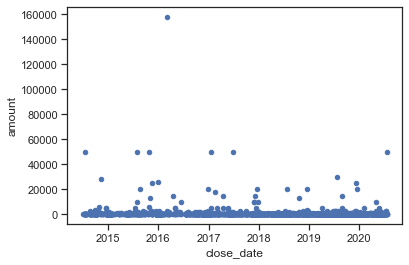

In [37]:
#Visualize donations over time
dons = donations.plot.scatter('close_date', 'amount')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


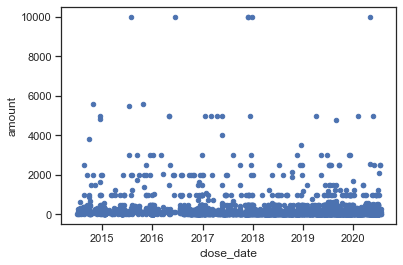

In [38]:
dons = donations_no_outlier_amts.plot.scatter('close_date', 'amount')

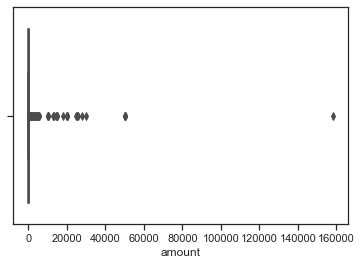

In [39]:
sns.boxplot(x=donations['amount'])

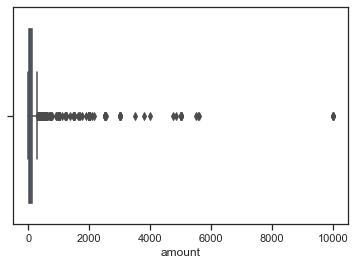

In [40]:
sns.boxplot(x=donations_no_outlier_amts['amount'])

In [41]:
donations.loc[donations['amount']>40000, ['account_id','type', 'amount', 'close_date', 'fund']]

,account_id,type,amount,close_date,fund
413,0013600000VKRVh,Pledge Payment,50000.00,2017-06-28,25th Anniversary Capital Campaign
575,0013p00001uSMBr,Grant,50000.00,2020-07-18,Annual Fund
1099,0013600000VKQpB,Board,50000.00,2017-01-20,25th Anniversary Capital Campaign
1721,0013600000VKR7B,Gift,158115.36,2016-03-07,Next Stage Campaign
2776,0013600000VKQlS,Gift,50000.00,2015-08-03,Annual Fund
2777,0013600000VKQlS,Gift,50000.00,2014-07-21,Annual Fund
3241,0013600000VKRb8,Pledge Payment,50000.00,2015-10-27,Next Stage Campaign


In [42]:
#Remove the 6 outliers above (those above 40k) as well as donations marked stage == 'Refunded'
less_max = donations[(donations['amount']<40000) & (donations['donation_record_type'] != 'Pledge')]

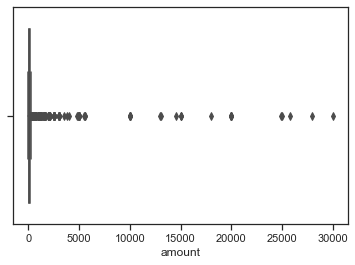

In [43]:
sns.boxplot(x=less_max['amount'])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


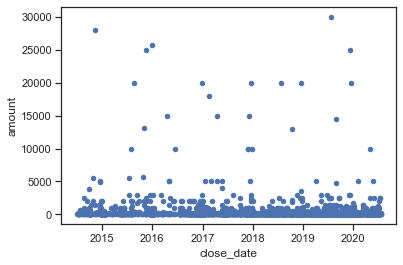

In [44]:
less_max_scatter = less_max.plot.scatter('close_date', 'amount')

In [45]:
#Find donation volume by date (excludes donations over 40,000 and refunds)
donations_by_date = less_max.groupby('close_date')['donation_id'].count()
donations_by_date.head()

close_date
2014-07-01    1
2014-07-09    4
2014-07-16    5
2014-07-21    1
2014-07-28    7
Name: donation_id, dtype: int64

In [46]:
donations_by_date_noout = donations_no_outlier_amts.groupby('close_date')['donation_id'].count()
donations_by_date_noout.head()

close_date
2014-07-01    1
2014-07-09    4
2014-07-16    5
2014-07-21    1
2014-07-28    7
Name: donation_id, dtype: int64

In [52]:
don_vol = donations.loc[(~donations.amount.isna()) & (donations['amount'] != 0)]
don_vol_by_date = don_vol.groupby('close_date')['donation_id'].count()
don_vol_by_date.head()

close_date
2014-07-01    1
2014-07-09    4
2014-07-16    5
2014-07-21    2
2014-07-28    7
Name: donation_id, dtype: int64

In [141]:
don_vol_by_date.tail(25)

close_date
2020-06-12      3
2020-06-13      1
2020-06-15     18
2020-06-16      5
2020-06-17      1
2020-06-21      1
2020-06-22      3
2020-06-23     10
2020-06-24      6
2020-06-25     23
2020-06-26     27
2020-06-27      6
2020-06-28     13
2020-06-29     78
2020-06-30    197
2020-07-01      2
2020-07-02      2
2020-07-03      8
2020-07-04      2
2020-07-06      1
2020-07-09      1
2020-07-10      5
2020-07-16      4
2020-07-18      4
2020-07-20      1
Name: donation_id, dtype: int64

Text(0.5, 0, 'Date')

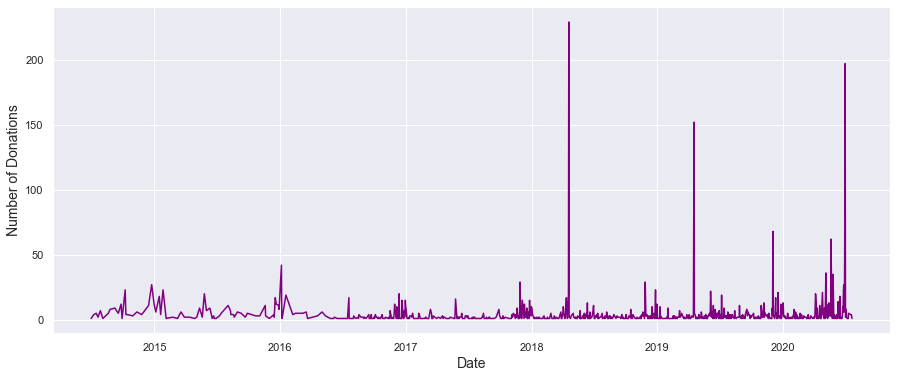

In [53]:
#Plot the daily donation volume

#set style
sns.set(style='darkgrid')

#Adjust the plot size
plt.figure(figsize=[15,6])

#Line Plot
sns.lineplot(x=don_vol_by_date.index, y=don_vol_by_date.values, color='purple')

#Assign axis labels:
plt.ylabel('Number of Donations', fontsize=14)
plt.xlabel('Date', fontsize=14)

In [55]:
#Which date over the analysis period had the largest donation volume?
donations.close_date.mode()

#04-19-2018 makes sense as it was our first giveoutday

0   2018-04-19
dtype: datetime64[ns]

In [60]:
#Fill nan in donations['amount'] with 0
donations.loc[donations['amount'].isna(), 'amount'] = 0
#Check it
donations[donations['donation_record_type'] == 'Pledge']

,donation_id,donation_record_type,amount,close_date,account_id,account_record_type,contact_id,pledge_amount,fund,payment_type,...,group_sales_total,ticket_order_id,total_amount,transaction_id,last_transaction_id,order_count_last_#_days,mailing_city,mailing_state,mailing_zip,campaign
1517,0063600000BpB9G,Pledge,0.0,2015-08-03,0013600000VKQlu,Household,0033600000NZkdZ,3000.00,NaN,NaN,...,0.0,NaN,0.0,nan,NaN,7.0,Richmond,VA,23230-4411,Outside of Campaign Period (S23)
1541,0063600000BpB9C,Pledge,0.0,2015-08-01,0013600000VKQqT,Household,0033600000NZkQL,1500.00,NaN,NaN,...,0.0,NaN,0.0,nan,NaN,8.0,Glen Allen,VA,23060-6199,Outside of Campaign Period (S23)
1542,0063600000BpB9B,Pledge,0.0,2015-08-01,0013600000VKQqT,Household,0033600000NZkQL,600.00,NaN,NaN,...,0.0,NaN,0.0,nan,NaN,8.0,Glen Allen,VA,23060-6199,Outside of Campaign Period (S23)
1574,0063600000GVNJa,Pledge,0.0,2016-12-30,0013600000VKRZd,Individual,0033600000NZkkJ,100000.00,25th Anniversary Capital Campaign,NaN,...,0.0,NaN,0.0,nan,NaN,5.0,RICHMOND,VA,23229,Outside of Campaign Period (S24)
1751,0063600000eiOyq,Pledge,0.0,2018-05-02,0013600000VKQqJ,Household,0033600000NZkqA,2500.00,Annual Fund,NaN,...,0.0,NaN,0.0,nan,NaN,2.0,Richmond,VA,23222,Outside of Campaign Period (S25)
1763,0063600000EdAey,Pledge,0.0,2016-07-29,0013600000VKRG9,Individual,0033600000NZkRL,420.00,Annual Fund,NaN,...,0.0,NaN,0.0,nan,NaN,0.0,Richmond,VA,23228-5548,Outside of Campaign Period (S24)
1818,0063600000BpB8M,Pledge,0.0,2015-11-25,0013600000VKR8S,Individual,0033600000NZkqY,720.00,NaN,NaN,...,0.0,NaN,0.0,nan,NaN,0.0,Richmond,VA,23228-5548,Outside of Campaign Period (S23)
1916,0061R00000q863b,Pledge,0.0,2019-06-18,0013600000VKRcL,Individual,0033600000NZkMG,500.00,Annual Fund,NaN,...,0.0,NaN,0.0,nan,NaN,1.0,Richmond,VA,23220-3526,Spring 2019 Annual Fund Appeal (S26)
1965,0063600000BpB8z,Pledge,0.0,2016-01-18,0013600000VKRmy,Individual,0033600000NZkWg,25000.00,NaN,NaN,...,0.0,NaN,0.0,nan,NaN,3.0,Richmond,VA,23220,Outside of Campaign Period (S23)
2409,0063p00000x39lI,Pledge,0.0,2020-06-15,0013600000VKQlg,Government,0033600001nRzJP,2000.00,Annual Fund,NaN,...,0.0,NaN,0.0,nan,NaN,0.0,Richmond,VA,23219,Spring 2020 Annual Fund Appeal (S27)


In [62]:
#Convert nan in fund column (except for pledges) to Annual Fund.
#Also, replace other AF categories with 'Annual Fund'
donations_no_outlier_amts.loc[(((donations_no_outlier_amts['fund'].isna()) | (donations_no_outlier_amts['fund'].isin(["Annual Fund Historical", 'ANN']))) & (donations_no_outlier_amts['donation_record_type'] != 'Pledge')), 'fund'] = "Annual Fund"

In [63]:
donations_no_outlier_amts.loc[(donations_no_outlier_amts['donation_record_type'] != 'Pledge') & (donations['account_record_type'] != 'Business') & (donations['fund'].isna()), 'fund'] = 'Annual Fund'

In [78]:
#Group levels referencing the same fund under common levels
donations_no_outlier_amts.loc[(donations_no_outlier_amts['fund'].isin(["25th Anniversary Campaign Fund", '25th Anniversary Fund', '25TH'])), 'fund'] = "25th Anniversary Capital Campaign"
donations_no_outlier_amts.loc[(donations_no_outlier_amts['fund'] == 'NEXT'), 'fund'] = "Next Stage Campaign"
donations_no_outlier_amts.loc[(donations_no_outlier_amts['fund'] == 'John Knapp -Tim Gillham Fund'), 'fund'] = "New Works (Knapp-Gillham) Fund"
donations_no_outlier_amts.loc[(donations_no_outlier_amts['fund'].isin(["Education Program Fund", 'EDUC'])), 'fund'] = "Education Fund"
donations_no_outlier_amts.loc[(donations_no_outlier_amts['fund'] == 'MMP'), 'fund'] = "Mary Morton Parsons Challenge Grant Match"

In [65]:
#Change record marked as single ticket sale in fund to Annual Fund (fix in database before next pull):
donations_no_outlier_amts.loc[(donations_no_outlier_amts['fund'] == 'Single Ticket Sale'), 'fund'] = "Annual Fund"

In [66]:
#Check fund column value changes
donations_no_outlier_amts.fund.value_counts()

Annual Fund                                  3816
Next Stage Campaign                            78
Advertiser                                     69
25th Anniversary Capital Campaign              64
Sponsorship Fund                               24
Education Fund                                 22
Mary Morton Parsons Challenge Grant Match      11
Moose Management Academy Attendance             8
Project Fund                                    5
New Works (Knapp-Gillham) Fund                  5
Building Fund                                   3
Name: fund, dtype: int64

In [67]:
donations_no_outlier_amts.payment_type.value_counts()

Credit Card                  1472
Credit Card - Third Party    1141
Check                        1049
Ticket Order Refund           147
CRED                          146
In Kind                        13
INKND                          10
Stock                           8
Cash                            7
Third Party                     1
Name: payment_type, dtype: int64

In [68]:
#Assign group levels referencing the same payment_type to common levels
donations_no_outlier_amts.loc[(donations_no_outlier_amts['payment_type'] == 'CRED'), 'payment_type'] = "Credit Card"
donations_no_outlier_amts.loc[(donations_no_outlier_amts['payment_type'] == 'Third Party'), 'payment_type'] = "Credit Card - Third Party"
donations_no_outlier_amts.loc[(donations_no_outlier_amts['payment_type'] == 'INKND'), 'payment_type'] = "In Kind"

In [69]:
donations_no_outlier_amts.payment_type.value_counts()

Credit Card                  1618
Credit Card - Third Party    1142
Check                        1049
Ticket Order Refund           147
In Kind                        23
Stock                           8
Cash                            7
Name: payment_type, dtype: int64

In [70]:
donations_no_outlier_amts.donation_record_type.value_counts(dropna=False)

Donation                 2896
PatronTicket Donation    1019
Pledge Payment            168
Corporate Donation         16
Sponsorship                 4
Grant Payment               2
Name: donation_record_type, dtype: int64

In [71]:
#Define function to show value counts of categorical vars specified in column list input
def cat_col_value_counts(df, cat_col_list):
    x=[]
    """
    Prints value counts of each categorical variable from df that is listed in cat_col_list 

    Params
    ------
    df : pandas.DataFrame
        dataframe containing columns in cat_col_list
    cat_col_list : list
        list of column names for which value counts will be printed

    Returns
    -------
    prints value counts for each variable in cat_col_list
    """

    for cat_col in cat_col_list:
         x.append(df[cat_col].value_counts(dropna= False))
    print (x)

In [72]:
cat_col_list = ['account_record_type', 'type', 'frequency', 'payment_schedule', 'stage', 'card_type', 'donation_origin', 'mailing_city', 'mailing_state']

In [73]:
cat_col_value_counts(donations_no_outlier_amts, cat_col_list)

[Individual    2385
Household     1593
Business       112
Foundation      11
Government       2
NaN              2
Name: account_record_type, dtype: int64, NaN                 1697
Gift                1036
Give OUT Day         855
GIVINGTUESDAYNOW     217
Pledge Payment       100
Board                 93
Sale                  60
General               22
Restricted            12
Unrestricted           7
Single                 4
Grant                  1
Matching               1
Name: type, dtype: int64, NaN          2741
Single       1218
Recurring     146
Name: frequency, dtype: int64, NaN    4105
Name: payment_schedule, dtype: int64, Posted          4100
Pledged            2
Paid in Full       2
Not Posted         1
Name: stage, dtype: int64, NaN           2633
Visa           860
MasterCard     396
Amex           176
Discover        40
Name: card_type, dtype: int64, NaN                                2306
Ticket Order                        794
Online: Donation Form               497
T

Create campaign column

In [74]:
#Assign regular appeal campaigns
donations_no_outlier_amts.loc[(donations_no_outlier_amts['type'] == 'GIVINGTUESDAYNOW'), 'campaign'] = 'GIVINGTUESDAYNOW (S27)'
donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] > '2020-06-05') & (donations_no_outlier_amts['close_date'] < '2020-08-01') & (donations_no_outlier_amts['fund'] == 'Annual Fund'), 'campaign'] = 'Spring 2020 Annual Fund Appeal (S27)'
donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] > '2019-11-19') & (donations_no_outlier_amts['close_date'] < '2020-02-01') & (donations_no_outlier_amts['fund'] == 'Annual Fund'), 'campaign'] = 'Fall 2019 Annual Fund Appeal (S27)'
donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] > '2019-05-20') & (donations_no_outlier_amts['close_date'] < '2019-08-01') & (donations_no_outlier_amts['fund'] == 'Annual Fund'), 'campaign'] = 'Spring 2019 Annual Fund Appeal (S26)'
donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] > '2018-11-25') & (donations_no_outlier_amts['close_date'] < '2019-02-01') & (donations_no_outlier_amts['fund'] == 'Annual Fund'), 'campaign'] = 'Fall 2018 Annual Fund Appeal (S26)'
donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] > '2018-05-20') & (donations_no_outlier_amts['close_date'] < '2018-08-01') & (donations_no_outlier_amts['fund'] == 'Annual Fund'), 'campaign'] = 'Spring 2018 Annual Fund Appeal (S25)'
donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] > '2017-11-10') & (donations_no_outlier_amts['close_date'] < '2018-02-01') & (donations_no_outlier_amts['fund'] == 'Annual Fund'), 'campaign'] = 'Fall 2017 Annual Fund Appeal (S25)'
donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] > '2016-11-14') & (donations_no_outlier_amts['close_date'] < '2017-02-01') & (donations_no_outlier_amts['fund'] == 'Annual Fund'), 'campaign'] = 'Fall 2016 Annual Fund Appeal (S24)'
donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] > '2015-11-14') & (donations_no_outlier_amts['close_date'] < '2016-02-01') & (donations_no_outlier_amts['fund'] == 'Annual Fund'), 'campaign'] = 'Fall 2015 Annual Fund Appeal (S23)'
donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] > '2014-11-14') & (donations_no_outlier_amts['close_date'] < '2015-02-01') & (donations_no_outlier_amts['fund'] == 'Annual Fund'), 'campaign'] = 'Fall 2014 Annual Fund Appeal (S22)'
donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] > '2020-04-30') & (donations_no_outlier_amts['close_date'] < '2020-08-01') & (donations_no_outlier_amts['type'] == 'Give OUT Day') & (donations_no_outlier_amts['fund'] == 'Annual Fund'), 'campaign'] = 'Give OUT Day (S27)'
donations_no_outlier_amts.loc[((donations_no_outlier_amts['fiscal_year'] == '2019') | (donations_no_outlier_amts['close_date'] == '2019-07-19')) & (donations_no_outlier_amts['type'] == 'Give OUT Day') & (donations_no_outlier_amts['fund'] == 'Annual Fund'), 'campaign'] = 'Give OUT Day (S26)'
donations_no_outlier_amts.loc[((donations_no_outlier_amts['fiscal_year'] == '2018') | (donations_no_outlier_amts['close_date'] == '2020-03-10')) & (donations_no_outlier_amts['type'] == 'Give OUT Day') & (donations_no_outlier_amts['fund'] == 'Annual Fund'), 'campaign'] = 'Give OUT Day (S25)'

In [75]:
donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] > '2019-06-30') & (donations_no_outlier_amts['close_date'] < '2020-07-01') & (donations_no_outlier_amts['campaign'].isna()), 'campaign'] = 'Outside of Campaign Period (S27)'
donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] > '2018-06-30') & (donations_no_outlier_amts['close_date'] < '2019-07-01') & (donations_no_outlier_amts['campaign'].isna()), 'campaign'] = 'Outside of Campaign Period (S26)'
donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] > '2017-06-30') & (donations_no_outlier_amts['close_date'] < '2018-07-01') & (donations_no_outlier_amts['campaign'].isna()), 'campaign'] = 'Outside of Campaign Period (S25)'
donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] > '2016-06-30') & (donations_no_outlier_amts['close_date'] < '2017-07-01') & (donations_no_outlier_amts['campaign'].isna()), 'campaign'] = 'Outside of Campaign Period (S24)'
donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] > '2015-06-30') & (donations_no_outlier_amts['close_date'] < '2016-07-01') & (donations_no_outlier_amts['campaign'].isna()), 'campaign'] = 'Outside of Campaign Period (S23)'
donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] > '2014-06-30') & (donations_no_outlier_amts['close_date'] < '2015-07-01') & (donations_no_outlier_amts['campaign'].isna()), 'campaign'] = 'Outside of Campaign Period (S22)'

In [76]:
donations_no_outlier_amts.campaign.value_counts()

Outside of Campaign Period (S27)        544
Give OUT Day (S27)                      350
Give OUT Day (S25)                      343
Outside of Campaign Period (S26)        296
Fall 2019 Annual Fund Appeal (S27)      245
Outside of Campaign Period (S24)        229
GIVINGTUESDAYNOW (S27)                  216
Fall 2017 Annual Fund Appeal (S25)      206
Spring 2019 Annual Fund Appeal (S26)    199
Outside of Campaign Period (S25)        199
Fall 2016 Annual Fund Appeal (S24)      196
Outside of Campaign Period (S22)        181
Fall 2018 Annual Fund Appeal (S26)      165
Give OUT Day (S26)                      162
Spring 2018 Annual Fund Appeal (S25)    137
Outside of Campaign Period (S23)        124
Fall 2015 Annual Fund Appeal (S23)      117
Spring 2020 Annual Fund Appeal (S27)     99
Fall 2014 Annual Fund Appeal (S22)       97
Name: campaign, dtype: int64

In [57]:
#Show all donations by fiscal year
donations_by_fiscal_year = donations_no_outlier_amts[(donations_no_outlier_amts['donation_record_type'] != 'Pledge')].groupby('fiscal_year')['amount'].sum()
donations_by_fiscal_year

fiscal_year
2015     85162.32
2016    120678.82
2017    117786.26
2018    129134.47
2019    117417.11
2020    231452.89
2021     10060.26
Name: amount, dtype: float64

Text(0.5, 0, 'Fiscal Year')

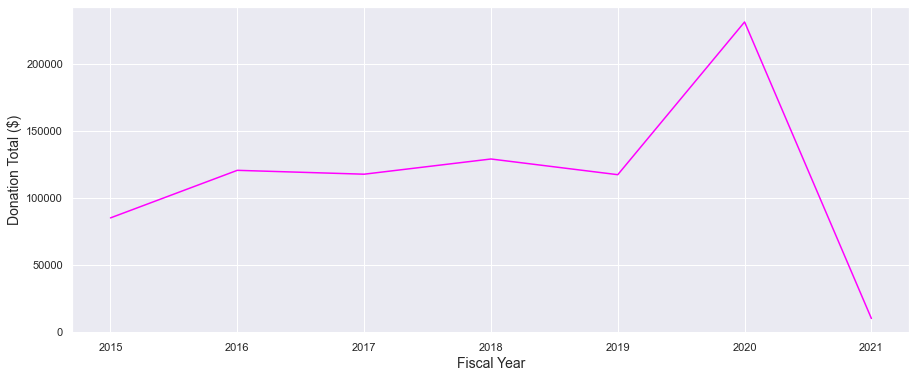

In [77]:
#Plot the FY donation volume

#set style
sns.set(style='darkgrid')

#Adjust the plot size
plt.figure(figsize=[15,6])

#Line Plot
sns.lineplot(x=donations_by_fiscal_year.index, y=donations_by_fiscal_year.values, color='magenta')

#Assign axis labels:
plt.ylabel('Donation Total ($)', fontsize=14)
plt.xlabel('Fiscal Year', fontsize=14)

In [142]:
#Plot the FY donation volume

#set style
#sns.set(style='darkgrid')

#Adjust the plot size
#plt.figure(figsize=[15,6])

#Line Plot
#sns.lineplot(x=donations.index, y=donations.values, color='magenta')

#Assign axis labels:
#plt.ylabel('Donation Total ($)', fontsize=14)
#plt.xlabel('Fiscal Year', fontsize=14)

Exception: Data must be 1-dimensional

<Figure size 1080x432 with 0 Axes>

In [79]:
#Show donation totals by fund and fiscal year
donations_by_fy_fund = donations_no_outlier_amts[(donations_no_outlier_amts['donation_record_type'] != 'Pledge')].groupby(['fund','fiscal_year'])['amount'].sum()
donations_by_fy_fund

fund                                       fiscal_year
25th Anniversary Capital Campaign          2016            38775.00
                                           2017            51301.92
                                           2018            50173.10
                                           2019             4690.49
                                           2020            11000.00
Advertiser                                 2015             5350.00
                                           2016             7125.00
                                           2019              210.00
                                           2020            11780.00
Annual Fund                                2015            45344.65
                                           2016            42712.72
                                           2017            65844.34
                                           2018            74461.37
                                           2019           103

In [80]:
#Visualize annual fund donations by date
af_donations_by_close_date = donations_no_outlier_amts[(donations['fund'] == 'Annual Fund') & (donations_no_outlier_amts['donation_record_type'] != 'Pledge')].groupby('close_date')['amount'].sum()
af_donations_by_close_date.head()

/Users/georgesmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



close_date
2014-07-01      30.0
2014-07-09     409.0
2014-07-16     485.0
2014-07-21     100.0
2014-07-28    1200.0
Name: amount, dtype: float64

Text(0.5, 1.0, 'Annual Fund Donation Totals Per Day')

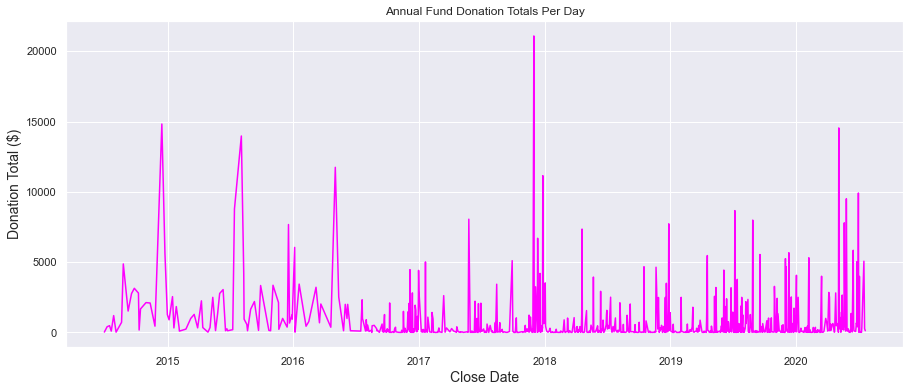

In [143]:
#Plot the daily annual fund donation totals

#set style
sns.set(style='darkgrid')

#Adjust the plot size
plt.figure(figsize=[15,6])

#Line Plot
sns.lineplot(x=af_donations_by_close_date.index, y=af_donations_by_close_date.values, color='magenta')

#Assign axis labels:
plt.ylabel('Donation Total ($)', fontsize=14)
plt.xlabel('Close Date', fontsize=14)
plt.title('Annual Fund Donation Totals Per Day')

In [83]:
#Visualize mean annual fund donations by FY
af_donations_mean_by_fy = donations_no_outlier_amts[(donations_no_outlier_amts['fund'] == 'Annual Fund') & (donations_no_outlier_amts['donation_record_type'] != 'Pledge')].groupby('fiscal_year')['amount'].mean()
af_donations_mean_by_fy

fiscal_year
2015    216.960048
2016    268.633459
2017    165.854761
2018     89.820712
2019    133.316047
2020    129.529119
2021    346.905517
Name: amount, dtype: float64

Text(0.5, 1.0, 'Annual Fund Donation Means By Fiscal Year')

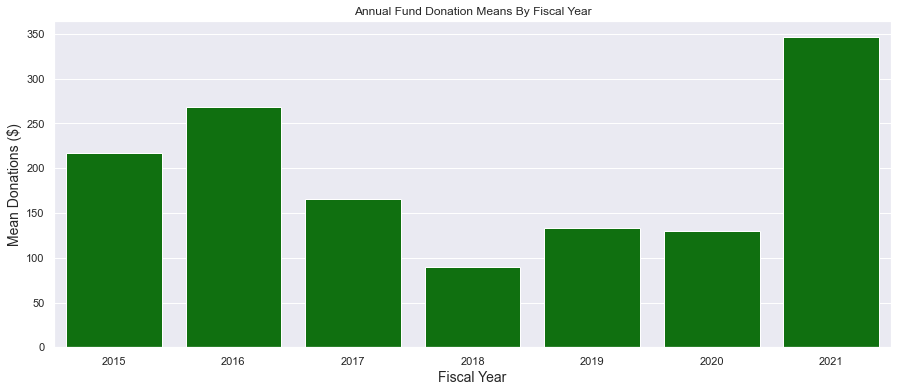

In [84]:
#Plot the annual fund means by fiscal year

#set style
sns.set(style='darkgrid')

#Adjust the plot size
plt.figure(figsize=[15,6])

#Line Plot
sns.barplot(x=af_donations_mean_by_fy.index, y=af_donations_mean_by_fy.values, color='green')

#Assign axis labels:
plt.ylabel('Mean Donations ($)', fontsize=14)
plt.xlabel('Fiscal Year', fontsize=14)
plt.title('Annual Fund Donation Means By Fiscal Year')

In [85]:
pd.DataFrame(af_donations_mean_by_fy).T

fiscal_year,2015,2016,2017,2018,2019,2020,2021
amount,216.960048,268.633459,165.854761,89.820712,133.316047,129.529119,346.905517


In [86]:
#Visualize annual fund donation volume by FY
af_donations_vol_by_fy = donations_no_outlier_amts[(donations_no_outlier_amts['fund'] == 'Annual Fund') & (donations_no_outlier_amts['donation_record_type'] != 'Pledge')].groupby('fiscal_year')['amount'].count()
af_donations_vol_by_fy

fiscal_year
2015     209
2016     159
2017     397
2018     829
2019     774
2020    1419
2021      29
Name: amount, dtype: int64

Text(0.5, 1.0, 'Annual Fund Donation Volume By Fiscal Year')

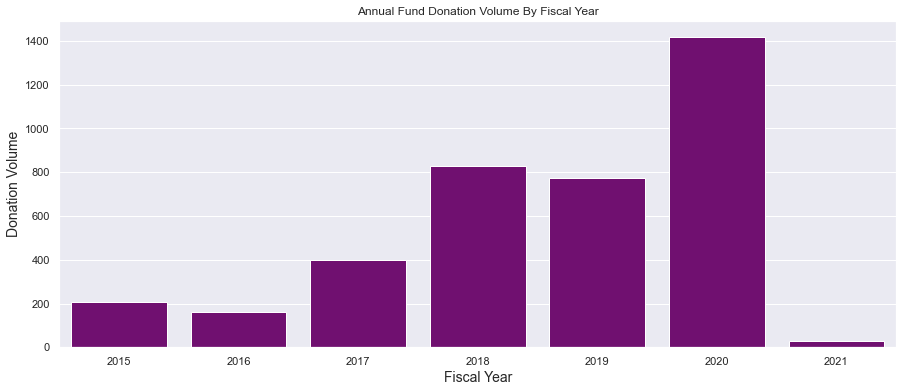

In [87]:
#Plot the annual fund volume by fiscal year

#set style
sns.set(style='darkgrid')

#Adjust the plot size
plt.figure(figsize=[15,6])

#Line Plot
sns.barplot(x=af_donations_vol_by_fy.index, y=af_donations_vol_by_fy.values, color='purple')

#Assign axis labels:
plt.ylabel('Number of Donors', fontsize=14)
plt.xlabel('Fiscal Year', fontsize=14)
plt.title('Annual Fund Donation Volume By Fiscal Year')

In [90]:
#AF Donations by FY
donations_no_outlier_amts[(donations_no_outlier_amts['fund'] == 'Annual Fund')].groupby('fiscal_year')['amount'].sum()

fiscal_year
2015     45344.65
2016     42712.72
2017     65844.34
2018     74461.37
2019    103186.62
2020    183801.82
2021     10060.26
Name: amount, dtype: float64

In [ ]:
#Visualize donations by campaign
#donations_by_campaign = donations[(donations['donation_record_type'] != 'Pledge')].groupby('campaign')['amount'].sum()
#donations_by_campaign.reindex(['Outside of Campaign Period (S22)', 'Fall 2014 Annual Fund Appeal (S22)', 'Outside of Campaign Period (S23)', 'Fall 2015 Annual Fund Appeal (S23)', 'Outside of Campaign Period (S24)', 'Fall 2016 Annual Fund Appeal (S24)', 'Outside of Campaign Period (S25)', 'Fall 2017 Annual Fund Appeal (S25)', 'Spring 2018 Annual Fund Appeal (S25)', 'Outside of Campaign Period (S26)', 'Fall 2018 Annual Fund Appeal (S26)', 'Spring 2019 Annual Fund Appeal (S26)', 'Outside of Campaign Period (S27)', 'Fall 2019 Annual Fund Appeal (S27)', 'GIVINGTUESDAYNOW (S27)', 'Spring 2020 Annual Fund Appeal (S27)'])

In [ ]:
#Plot the daily donation volume

#set style
#sns.set(style='darkgrid')

#Adjust the plot size
#plt.figure(figsize=[15,6])

#Line Plot
#sns.lineplot(x=donations_by_campaign.index, y=donations_by_campaign.values, color='green')

#Assign axis labels:
#plt.ylabel('Donation Total ($)', fontsize=14)
#plt.xlabel('Campaign Period', fontsize=14)
#plt.xticks(rotation=90)

In [ ]:
# pledges = donations.loc[donations['donation_record_type'] == 'Pledge', 
#                         ['donation_id', 'donation_record_type', 'amount',
#        'close_date', 'account_name', 'account_id', 'account_record_type',
#        'contact_id', 'pledge_amount', 'fund', 
#        'fiscal_year', 'type', 'first_donation_date', 'last_donation_amount',
#        'last_donation_date', 'lifetime_donation_count',
#        'lifetime_donation_total_amount', 'lifetime_order_count',
#        'lifetime_single_ticket_purchase_total',
#        'lifetime_subscription_purchase_total', 'account_created_date', 'account_phone', 'amount_donated_last_365_days',
#        'amount_donated_last_fiscal_year', 'amount_donated_this_fiscal_year',
#        'ticket_order_id', 'order_count_last_#_days',
#        'mailing_street', 'mailing_city', 'mailing_state', 'mailing_zip',
#        'campaign']]

In [ ]:
# #Filter refunded out of donations; select columns for analysis
# donations = donations.loc[(donations['stage'] != 'Refunded') & (donations['donation_record_type'] != 'Pledge'), 
#                           ['donation_id', 'donation_record_type', 'amount',
#        'close_date', 'account_name', 'account_id', 'account_record_type',
#        'contact_id', 'pledge_amount', 'fund', 
#        'fiscal_year', 'type', 'first_donation_date', 'last_donation_amount',
#        'last_donation_date', 'lifetime_donation_count',
#        'lifetime_donation_total_amount', 'lifetime_order_count',
#        'lifetime_single_ticket_purchase_total',
#        'lifetime_subscription_purchase_total', 'account_created_date', 'account_phone', 'amount_donated_last_365_days',
#        'amount_donated_last_fiscal_year', 'amount_donated_this_fiscal_year',
#        'ticket_order_id', 'order_count_last_#_days',
#        'mailing_street', 'mailing_city', 'mailing_state', 'mailing_zip',
#        'campaign']]

# Stewardship Program Analysis

Create stewardship level columns

In [91]:
#Only Annual Fund dontations made by Household or Individual donors are included in stewardship program totals
donations_no_outlier_amts['stp_total_s27'] = donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] >= '2018-07-01') & (donations_no_outlier_amts['fund'] == 'Annual Fund') & (donations_no_outlier_amts['account_record_type'].isin(['Household', 'Individual']))].groupby('account_id')['amount'].transform('sum')
donations_no_outlier_amts['stp_total_s26'] = donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] >= '2017-07-01') & (donations_no_outlier_amts['close_date'] <= '2019-06-30') & (donations_no_outlier_amts['fund'] == 'Annual Fund') & (donations_no_outlier_amts['account_record_type'].isin(['Household', 'Individual']))].groupby('account_id')['amount'].transform('sum')
donations_no_outlier_amts['stp_total_s25'] = donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] >= '2016-07-01') & (donations_no_outlier_amts['close_date'] <= '2018-06-30') & (donations_no_outlier_amts['fund'] == 'Annual Fund') & (donations_no_outlier_amts['account_record_type'].isin(['Household', 'Individual']))].groupby('account_id')['amount'].transform('sum')
donations_no_outlier_amts['stp_total_s24'] = donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] >= '2015-07-01') & (donations_no_outlier_amts['close_date'] <= '2017-06-30') & (donations_no_outlier_amts['fund'] == 'Annual Fund') & (donations_no_outlier_amts['account_record_type'].isin(['Household', 'Individual']))].groupby('account_id')['amount'].transform('sum')
donations_no_outlier_amts['stp_total_s23'] = donations_no_outlier_amts.loc[(donations_no_outlier_amts['close_date'] >= '2014-07-01') & (donations_no_outlier_amts['close_date'] <= '2016-06-30') & (donations_no_outlier_amts['fund'] == 'Annual Fund') & (donations_no_outlier_amts['account_record_type'].isin(['Household', 'Individual']))].groupby('account_id')['amount'].transform('sum')

In [92]:
#Fill NaNs with max value for that account_id shown in other rows for that particular stp_total_sXX column 
stp_total_cols = ['stp_total_s27', 'stp_total_s26', 'stp_total_s25', 'stp_total_s24', 'stp_total_s23']
for col in stp_total_cols:
    donations_no_outlier_amts.loc[donations_no_outlier_amts[col].isnull(), col] = donations_no_outlier_amts.groupby('account_id')[col].transform('max')

In [93]:
#Now, fill remaining nan in stp_total_sXX cols with 0 to simplify ufunc (stp_level_generator) below:  
donations_no_outlier_amts[['stp_total_s27', 'stp_total_s26', 'stp_total_s25', 'stp_total_s24', 'stp_total_s23']] = donations_no_outlier_amts.loc[:,['stp_total_s27', 'stp_total_s26', 'stp_total_s25', 'stp_total_s24', 'stp_total_s23']].fillna(0)

In [94]:
#Confirm by checking output for one account_id
donations_no_outlier_amts.loc[donations_no_outlier_amts['account_id'] == '0013600000VKRp8', ['stp_total_s27', 'stp_total_s26', 'stp_total_s25', 'stp_total_s24', 'stp_total_s23'] ]

,stp_total_s27,stp_total_s26,stp_total_s25,stp_total_s24,stp_total_s23
364,615.0,455.0,642.0,502.0,0.0
365,615.0,455.0,642.0,502.0,0.0
1306,615.0,455.0,642.0,502.0,0.0
1307,615.0,455.0,642.0,502.0,0.0
2507,615.0,455.0,642.0,502.0,0.0
2508,615.0,455.0,642.0,502.0,0.0
2509,615.0,455.0,642.0,502.0,0.0
2510,615.0,455.0,642.0,502.0,0.0
2511,615.0,455.0,642.0,502.0,0.0
2512,615.0,455.0,642.0,502.0,0.0


In [95]:
donations_no_outlier_amts.isna().sum()

donation_id                                 0
donation_record_type                        0
amount                                      0
close_date                                  0
account_id                                  2
account_record_type                         2
contact_id                                  0
pledge_amount                            4105
fund                                        0
payment_type                              111
fiscal_quarter                              0
fiscal_year                                 0
type                                     1697
frequency                                2741
amount_matched                              0
first_donation_date                         2
last_donation_amount                        5
last_donation_date                          2
lifetime_donation_count                     2
lifetime_donation_total_amount              2
lifetime_order_count                        2
lifetime_single_ticket_purchase_to

# Translate stewardship amount by season into stewardship level by account_id

In [96]:
def stp_level_generator(series):
    if series == 0:
        return 'Did Not Give'
    elif (series > 0) & (series < 125):
        return 'Pre-Steward'
    elif (series >= 125) & (series < 250):
        return 'Supporter'
    elif (series >= 250) & (series < 500):
        return 'Investor'
    elif (series >= 500) & (series < 1000):
        return 'Underwriter'
    elif (series >= 1000) & (series < 2500):
        return 'Performer'
    elif (series >= 2500) & (series < 5000):
        return 'Director'
    elif (series >= 5000):
        return 'Producer'

In [97]:
#Create new dataframe with account_id, stp_total_sX cols and corresponding stp_level cols: 
stp_amt_list = ['stp_total_s27', 'stp_total_s26', 'stp_total_s25', 'stp_total_s24', 'stp_total_s23']
levels_by_season_df = pd.DataFrame()
levels_by_season_df['account_id'] = donations_no_outlier_amts['account_id']

for col in stp_amt_list:
    levels_by_season_df[col] = donations_no_outlier_amts[col]
    col_name = col[:3] + col[9:] + '_level'
    levels_by_season_df[col_name] = (donations_no_outlier_amts[col].apply(stp_level_generator))

In [98]:
levels_by_season_df.head()

,account_id,stp_total_s27,stp_s27_level,stp_total_s26,stp_s26_level,stp_total_s25,stp_s25_level,stp_total_s24,stp_s24_level,stp_total_s23,stp_s23_level
0,0013600000VKQlu,1220.0,Performer,1120.0,Performer,100.00,Pre-Steward,0.00,Did Not Give,250.0,Investor
1,0013600000VKQlu,1220.0,Performer,1120.0,Performer,100.00,Pre-Steward,0.00,Did Not Give,250.0,Investor
2,0013600000VKRVZ,12392.0,Producer,981.0,Underwriter,1026.25,Performer,442.25,Investor,0.0,Did Not Give
3,0013600000VKRVZ,12392.0,Producer,981.0,Underwriter,1026.25,Performer,442.25,Investor,0.0,Did Not Give
4,0013600000VKRVZ,12392.0,Producer,981.0,Underwriter,1026.25,Performer,442.25,Investor,0.0,Did Not Give


In [99]:
#Remove duplicate rows based on account_id to show each donor's stewardship levels across the most recent 5 seasons
levels_by_season_df = levels_by_season_df.drop_duplicates(subset='account_id', keep='first').reset_index(drop='True')

In [100]:
#Check that all stewardship levels are present in each season
level_cols = ['stp_s23_level', 'stp_s24_level', 'stp_s25_level', 'stp_s26_level', 'stp_s27_level']
for col in level_cols:
    print(levels_by_season_df[col].value_counts())

Did Not Give    1330
Pre-Steward      126
Investor          30
Supporter         27
Underwriter       20
Performer         16
Director           6
Name: stp_s23_level, dtype: int64
Did Not Give    1184
Pre-Steward      228
Investor          46
Supporter         44
Underwriter       25
Performer         21
Director           7
Name: stp_s24_level, dtype: int64
Did Not Give    920
Pre-Steward     430
Supporter        77
Investor         49
Underwriter      40
Performer        35
Director          4
Name: stp_s25_level, dtype: int64
Did Not Give    813
Pre-Steward     494
Supporter        99
Investor         61
Performer        41
Underwriter      37
Director          7
Producer          3
Name: stp_s26_level, dtype: int64
Pre-Steward     757
Did Not Give    454
Supporter       121
Investor        101
Performer        54
Underwriter      52
Director         11
Producer          5
Name: stp_s27_level, dtype: int64


The producer level is missing from season 25. Add it below when creating that series.

In [101]:
stp_donors_s27 = (levels_by_season_df.groupby('stp_s27_level')['account_id'].count()).rename('stp_s27_level')
stp_donors_s27

stp_s27_level
Did Not Give    453
Director         11
Investor        101
Performer        54
Pre-Steward     757
Producer          5
Supporter       121
Underwriter      52
Name: stp_s27_level, dtype: int64

In [102]:
stp_donors_s26 = levels_by_season_df.groupby('stp_s26_level')['account_id'].count().rename('stp_s26_level')

In [107]:
stp_donors_s25 = levels_by_season_df.groupby('stp_s25_level')['account_id'].count().rename('stp_s25_level')

In [109]:
#stp_s25_level is has no 'Producer' level records. Add this level to the index with a value of 0.
stp_donors_s25.loc['Producer'] = 0

In [110]:
stp_donors_s25

stp_s25_level
Did Not Give    919
Director          4
Investor         49
Performer        35
Pre-Steward     430
Supporter        77
Underwriter      40
Producer          0
Name: stp_s25_level, dtype: int64

In [111]:
stp_donors_s24 = levels_by_season_df.groupby('stp_s24_level')['account_id'].count().rename('stp_s24_level')

In [118]:
#stp_s24_level is has no 'Producer' level records. Add this level to the index with a value of 0.
stp_donors_s24.loc['Producer'] = 0

In [112]:
stp_donors_s23 = levels_by_season_df.groupby('stp_s23_level')['account_id'].count().rename('stp_s23_level')

In [119]:
#stp_s23_level is has no 'Producer' level records. Add this level to the index with a value of 0.
stp_donors_s23.loc['Producer'] = 0

# Visualize change in level size across time (seasons)

In [120]:
#Concatenate the series above to facilitate visualizing stewardship levels by season
stp_level_dist = (pd.concat([stp_donors_s23, stp_donors_s24, stp_donors_s25, stp_donors_s26, stp_donors_s27], axis=1, join='inner', copy=False))

In [121]:
stp_level_dist

,stp_s23_level,stp_s24_level,stp_s25_level,stp_s26_level,stp_s27_level
Did Not Give,1329,1183,919,812,453
Director,6,7,4,7,11
Investor,30,46,49,61,101
Performer,16,21,35,41,54
Pre-Steward,126,228,430,494,757
Supporter,27,44,77,99,121
Underwriter,20,25,40,37,52
Producer,0,0,0,3,5


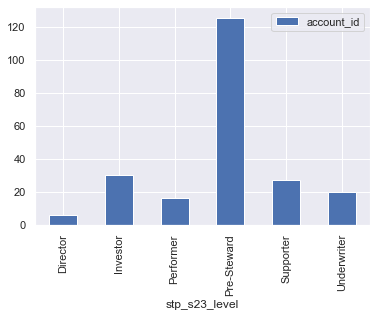

In [122]:
#Create bar chart showing donor volume by stewardship level for season 23
stp_23 = (levels_by_season_df.groupby('stp_s23_level')['account_id'].count().to_frame().iloc[1:]).plot(kind='bar', stacked=True)

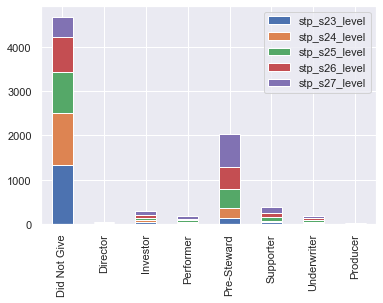

In [123]:
ax = stp_level_dist.plot(kind='bar', stacked=True)

Change row index for chart above so that the levels are in proper order.

In [124]:
stp_level_dist = stp_level_dist.loc[['Did Not Give', 'Pre-Steward', 'Supporter', 'Investor', 'Underwriter', 'Performer', 'Director', 'Producer']]
stp_level_dist.index

Index(['Did Not Give', 'Pre-Steward', 'Supporter', 'Investor', 'Underwriter',
       'Performer', 'Director', 'Producer'],
      dtype='object')

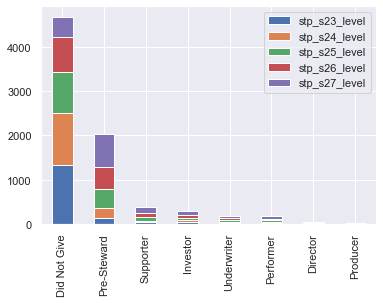

In [125]:
#Replot bar chart above with proper level order
ax = stp_level_dist.plot(kind='bar', stacked=True)

In [126]:
stp_level_dist.T

,Did Not Give,Pre-Steward,Supporter,Investor,Underwriter,Performer,Director,Producer
stp_s23_level,1329,126,27,30,20,16,6,0
stp_s24_level,1183,228,44,46,25,21,7,0
stp_s25_level,919,430,77,49,40,35,4,0
stp_s26_level,812,494,99,61,37,41,7,3
stp_s27_level,453,757,121,101,52,54,11,5


In [127]:
#Change the row labels to fix improve the bar charts
stp_level_dist.T.set_index(pd.Index(['Season 23', 'Season 24', 'Season 25', 'Season 26', 'Season 27']))

,Did Not Give,Pre-Steward,Supporter,Investor,Underwriter,Performer,Director,Producer
Season 23,1329,126,27,30,20,16,6,0
Season 24,1183,228,44,46,25,21,7,0
Season 25,919,430,77,49,40,35,4,0
Season 26,812,494,99,61,37,41,7,3
Season 27,453,757,121,101,52,54,11,5


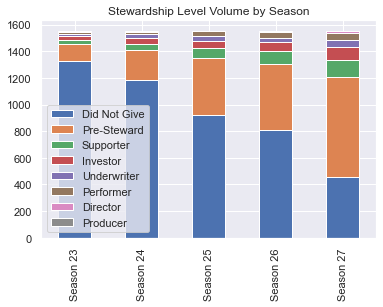

In [128]:
ax = stp_level_dist.T.set_index(pd.Index(['Season 23', 'Season 24', 'Season 25', 'Season 26', 'Season 27'])).plot(kind='bar', stacked=True, title='Stewardship Level Volume by Season')

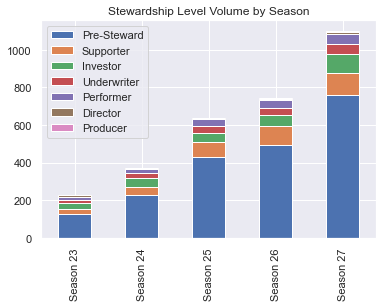

In [129]:
#Replot above without Did Not Give group in each season
stp_levels = stp_level_dist[1:].T.set_index(pd.Index(['Season 23', 'Season 24', 'Season 25', 'Season 26', 'Season 27'])).plot(kind='bar', stacked=True, title='Stewardship Level Volume by Season')

In [130]:
#Transform df to show stewardship level donor counts by season, including only the actual stewardship levels
stp_level_dist.T.set_index(pd.Index(['Season 23', 'Season 24', 'Season 25', 'Season 26', 'Season 27'])).loc[:,['Supporter', 'Investor', 'Underwriter', 'Performer', 'Director', 'Producer']]

,Supporter,Investor,Underwriter,Performer,Director,Producer
Season 23,27,30,20,16,6,0
Season 24,44,46,25,21,7,0
Season 25,77,49,40,35,4,0
Season 26,99,61,37,41,7,3
Season 27,121,101,52,54,11,5


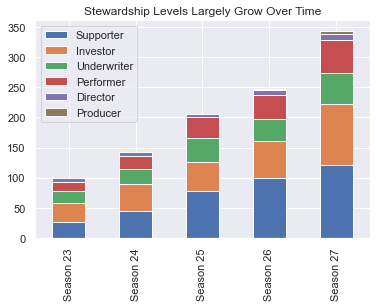

In [149]:
stp_stacked_bars = stp_level_dist.T.set_index(pd.Index(['Season 23', 'Season 24', 'Season 25', 'Season 26', 'Season 27'])).loc[:,['Supporter', 'Investor', 'Underwriter', 'Performer', 'Director', 'Producer']].plot(kind='bar', stacked=True, title='Stewardship Levels Largely Grow Over Time')

In [150]:
stp_level_counts = stp_level_dist.T.set_index(pd.Index(['Season 23', 'Season 24', 'Season 25', 'Season 26', 'Season 27'])).loc[:,['Supporter', 'Investor', 'Underwriter', 'Performer', 'Director', 'Producer']]
stp_level_counts

,Supporter,Investor,Underwriter,Performer,Director,Producer
Season 23,27,30,20,16,6,0
Season 24,44,46,25,21,7,0
Season 25,77,49,40,35,4,0
Season 26,99,61,37,41,7,3
Season 27,121,101,52,54,11,5


In [133]:
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = list(stp_level_counts.T.values[0])
bars2 = list(stp_level_counts.T.values[1])
bars3 = list(stp_level_counts.T.values[2])
bars4 = list(stp_level_counts.T.values[3])
bars5 = list(stp_level_counts.T.values[4])
bars6 = list(stp_level_counts.T.values[5])
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

print(r1, r2, r3, r4, r5, r6)

[0 1 2 3 4] [0.25, 1.25, 2.25, 3.25, 4.25] [0.5, 1.5, 2.5, 3.5, 4.5] [0.75, 1.75, 2.75, 3.75, 4.75] [1.0, 2.0, 3.0, 4.0, 5.0] [1.25, 2.25, 3.25, 4.25, 5.25]


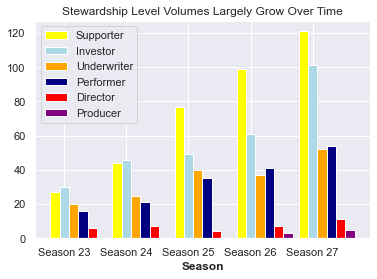

In [134]:
#Visualize stewardship level counts by season as a grouped barplot.

# set width of bar
barWidth = 0.150 #Resolved overlapping bars by reducing the width from .25 to .15
 
# set height of bar
bars1 = list(stp_level_counts.T.values[0])
bars2 = list(stp_level_counts.T.values[1])
bars3 = list(stp_level_counts.T.values[2])
bars4 = list(stp_level_counts.T.values[3])
bars5 = list(stp_level_counts.T.values[4])
bars6 = list(stp_level_counts.T.values[5])
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
 
# Make the plot
plt.bar(r1, bars1, color='yellow', width=barWidth, edgecolor='white', label='Supporter')
plt.bar(r2, bars2, color='lightblue', width=barWidth, edgecolor='white', label='Investor')
plt.bar(r3, bars3, color='orange', width=barWidth, edgecolor='white', label='Underwriter')
plt.bar(r4, bars4, color='navy', width=barWidth, edgecolor='white', label='Performer')
plt.bar(r5, bars5, color='red', width=barWidth, edgecolor='white', label='Director')
plt.bar(r6, bars6, color='purple', width=barWidth, edgecolor='white', label='Producer')

# Add xticks on the middle of the group bars
plt.xlabel('Season', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], list(stp_level_counts.index))
 
# Add title, Create legend and Show graphic
plt.title('Stewardship Level Volumes Largely Grow Over Time')
plt.legend()
plt.show()


In [135]:
stp_donor_counts = stp_level_dist.T.set_index(pd.Index(['Season 23', 'Season 24', 'Season 25', 'Season 26', 'Season 27'])).loc[:,['Pre-Steward', 'Supporter', 'Investor', 'Underwriter', 'Performer', 'Director', 'Producer']]
stp_donor_counts

,Pre-Steward,Supporter,Investor,Underwriter,Performer,Director,Producer
Season 23,126,27,30,20,16,6,0
Season 24,228,44,46,25,21,7,0
Season 25,430,77,49,40,35,4,0
Season 26,494,99,61,37,41,7,3
Season 27,757,121,101,52,54,11,5


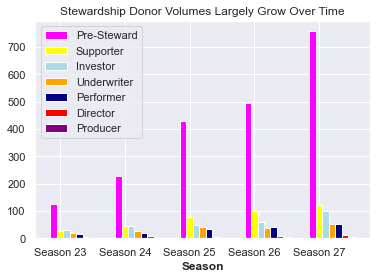

In [136]:
#Visualize stewardship donor counts by season as a grouped barplot.

# set width of bar
barWidth = 0.10 
 
# set height of bar
bars1 = list(stp_donor_counts.T.values[0])
bars2 = list(stp_donor_counts.T.values[1])
bars3 = list(stp_donor_counts.T.values[2])
bars4 = list(stp_donor_counts.T.values[3])
bars5 = list(stp_donor_counts.T.values[4])
bars6 = list(stp_donor_counts.T.values[5])
bars7 = list(stp_donor_counts.T.values[6])
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
 
# Make the plot
plt.bar(r1, bars1, color='magenta', width=barWidth, edgecolor='white', label='Pre-Steward')
plt.bar(r2, bars2, color='yellow', width=barWidth, edgecolor='white', label='Supporter')
plt.bar(r3, bars3, color='lightblue', width=barWidth, edgecolor='white', label='Investor')
plt.bar(r4, bars4, color='orange', width=barWidth, edgecolor='white', label='Underwriter')
plt.bar(r5, bars5, color='navy', width=barWidth, edgecolor='white', label='Performer')
plt.bar(r6, bars6, color='red', width=barWidth, edgecolor='white', label='Director')
plt.bar(r7, bars7, color='purple', width=barWidth, edgecolor='white', label='Producer')

# Add xticks on the middle of the group bars
plt.xlabel('Season', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], list(stp_level_counts.index))
 
# Add title, Create legend and Show graphic
plt.title('Stewardship Donor Volumes Largely Grow Over Time')
plt.legend()
plt.show()



Run a statistical test to determine if the number of donors in each level is statistically significantly higher than each of them in the previous season.

Examine growth rates in levels over time

In [137]:
stp_counts = stp_level_dist.T.set_index(pd.Index(['Season 23', 'Season 24', 'Season 25', 'Season 26', 'Season 27']))
stp_counts

,Did Not Give,Pre-Steward,Supporter,Investor,Underwriter,Performer,Director,Producer
Season 23,1329,126,27,30,20,16,6,0
Season 24,1183,228,44,46,25,21,7,0
Season 25,919,430,77,49,40,35,4,0
Season 26,812,494,99,61,37,41,7,3
Season 27,453,757,121,101,52,54,11,5


In [138]:
#Define function to generate growth rates in levels over time:

def stp_growth_rates_by_level(df, r, row_name_list):
    """
Params
    ------
    df : pandas.DataFrame
        dataframe with columns as stewardship levels and row index as seasons
    r : integer
        integer referencing max row index of the df

    Returns
    -------
    np.arrary
        Returns a numpy array with one fewer row dimension than the input df, 
        Each element shows the rounded percent change in each stewardship level value over the previous season
        
    """
    a = np.round_((100*(df.to_numpy()[1:,:] - df.to_numpy()[:r,:])/ df.to_numpy()[:r,:]), 2)
    a[np.isinf(a)] = 0
    x = pd.DataFrame(data=a,
                index=row_name_list,
                columns=df.columns)
    return x

In [139]:
perc_change_level_vol = stp_growth_rates_by_level(stp_counts, 4, ['% Change in Season 24', '% Change in Season 25', '% Change in Season 26', '% Change in Season 27'])
perc_change_level_vol

/Users/georgesmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning:

divide by zero encountered in true_divide

/Users/georgesmith/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in true_divide



,Did Not Give,Pre-Steward,Supporter,Investor,Underwriter,Performer,Director,Producer
% Change in Season 24,-10.99,80.95,62.96,53.33,25.00,31.25,16.67,NaN
% Change in Season 25,-22.32,88.60,75.00,6.52,60.00,66.67,-42.86,NaN
% Change in Season 26,-11.64,14.88,28.57,24.49,-7.50,17.14,75.00,0.00
% Change in Season 27,-44.21,53.24,22.22,65.57,40.54,31.71,57.14,66.67


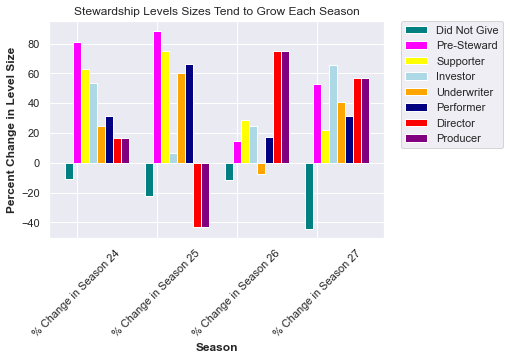

In [148]:
#Visualize percent change in stewardship level volume by season as a grouped barplot.

# set width of bar
barWidth = 0.10 
 
# set height of bar
bars1 = list(perc_change_level_vol.T.values[0])
bars2 = list(perc_change_level_vol.T.values[1])
bars3 = list(perc_change_level_vol.T.values[2])
bars4 = list(perc_change_level_vol.T.values[3])
bars5 = list(perc_change_level_vol.T.values[4])
bars6 = list(perc_change_level_vol.T.values[5])
bars7 = list(perc_change_level_vol.T.values[6])
bars8 = list(perc_change_level_vol.T.values[6])
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
 
# Make the plot
plt.bar(r1, bars1, color='teal', width=barWidth, edgecolor='white', label='Did Not Give')
plt.bar(r2, bars2, color='magenta', width=barWidth, edgecolor='white', label='Pre-Steward')
plt.bar(r3, bars3, color='yellow', width=barWidth, edgecolor='white', label='Supporter')
plt.bar(r4, bars4, color='lightblue', width=barWidth, edgecolor='white', label='Investor')
plt.bar(r5, bars5, color='orange', width=barWidth, edgecolor='white', label='Underwriter')
plt.bar(r6, bars6, color='navy', width=barWidth, edgecolor='white', label='Performer')
plt.bar(r7, bars7, color='red', width=barWidth, edgecolor='white', label='Director')
plt.bar(r8, bars8, color='purple', width=barWidth, edgecolor='white', label='Producer')

# Add xticks on the middle of the group bars
plt.xlabel('Season', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], list(perc_change_level_vol.index), rotation=45)
plt.ylabel('Percent Change in Level Size', fontweight='bold')
 
# Add title, Create legend and Show graphic
plt.title('Stewardship Levels Sizes Tend to Grow Each Season')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


In [ ]:
#function to create a statewise stacked plot of positive and negative cases
#def pandas_plot(covid_df):
#    ax = covid_df.iloc[:,[0,7]].plot(kind='bar',stacked=True,title = 'US Covid19 Stats By State as of '+max(covid_df['dateModified']),rot=0)
#    for lbl in ax.patches:
#        ax.annotate("{:.0f}".format(int(lbl.get_height())),\
#                    (lbl.get_x()+.25, lbl.get_height()+lbl.get_y()),\
#                    verticalalignment='bottom', horizontalalignment='center', \
#                    fontsize=7, color='black')
        
#if __name__ == '__main__':
#    state_list = ['NY','WA','CA','NJ'] #define list of states for which details are needed
#    covid_df = api_dataload(state_list) #pass the list of states to the api_dataloaf function
#    pandas_plot(covid_df) #use the consolidated covid_df to create stacked plot using pandas_plot function

# Visualize change in donation totals across time

Create a dataframe of donation totals & means by stewardship level over time.

In [162]:
stp_totals_s23 = levels_by_season_df.groupby('stp_s23_level')['stp_total_s23'].sum().rename('stp_totals_s23').sort_values()
stp_totals_s23

stp_s23_level
Did Not Give        0.00
Supporter        4940.00
Pre-Steward      7310.50
Investor         9065.90
Underwriter     11435.11
Director        17383.25
Performer       21914.07
Name: stp_totals_s23, dtype: float64

In [161]:
stp_means_s23 = levels_by_season_df.groupby('stp_s23_level')['stp_total_s23'].mean().rename('stp_means_s23').sort_values()
stp_means_s23

stp_s23_level
Did Not Give       0.000000
Pre-Steward       58.019841
Supporter        182.962963
Investor         302.196667
Underwriter      571.755500
Performer       1369.629375
Director        2897.208333
Name: stp_means_s23, dtype: float64

In [163]:
stp_totals_s24 = levels_by_season_df.groupby('stp_s24_level')['stp_total_s24'].sum().rename('stp_totals_s24').sort_values()
stp_totals_s24

stp_s24_level
Did Not Give        0.00
Supporter        8275.00
Pre-Steward      9007.16
Investor        13688.75
Underwriter     14682.99
Director        21786.33
Performer       28585.83
Name: stp_totals_s24, dtype: float64

In [165]:
stp_means_s24 = levels_by_season_df.groupby('stp_s24_level')['stp_total_s24'].mean().rename('stp_means_s24').sort_values()
stp_means_s24

stp_s24_level
Did Not Give       0.000000
Pre-Steward       39.505088
Supporter        188.068182
Investor         297.581522
Underwriter      587.319600
Performer       1361.230000
Director        3112.332857
Name: stp_means_s24, dtype: float64

In [166]:
stp_totals_s25 = levels_by_season_df.groupby('stp_s25_level')['stp_total_s25'].sum().rename('stp_totals_s25').sort_values()
stp_totals_s25

stp_s25_level
Did Not Give        0.00
Supporter       13787.50
Pre-Steward     14701.16
Director        14972.01
Investor        15484.75
Underwriter     24771.00
Performer       52039.29
Name: stp_totals_s25, dtype: float64

In [167]:
stp_means_s25 = levels_by_season_df.groupby('stp_s25_level')['stp_total_s25'].mean().rename('stp_means_s25').sort_values()
stp_means_s25

stp_s25_level
Did Not Give       0.000000
Pre-Steward       34.188744
Supporter        179.058442
Investor         316.015306
Underwriter      619.275000
Performer       1486.836857
Director        3743.002500
Name: stp_means_s25, dtype: float64

In [168]:
stp_totals_s26 = levels_by_season_df.groupby('stp_s26_level')['stp_total_s26'].sum().rename('stp_totals_s26').sort_values()
stp_totals_s26

stp_s26_level
Did Not Give        0.00
Pre-Steward     14971.41
Producer        15800.00
Supporter       16454.76
Investor        19232.70
Director        22688.00
Underwriter     22933.37
Performer       57358.75
Name: stp_totals_s26, dtype: float64

In [169]:
stp_means_s26 = levels_by_season_df.groupby('stp_s26_level')['stp_total_s26'].mean().rename('stp_means_s26').sort_values()
stp_means_s26

stp_s26_level
Did Not Give       0.000000
Pre-Steward       30.306498
Supporter        166.209697
Investor         315.290164
Underwriter      619.820811
Performer       1398.993902
Director        3241.142857
Producer        5266.666667
Name: stp_means_s26, dtype: float64

In [170]:
stp_totals_s27 = levels_by_season_df.groupby('stp_s27_level')['stp_total_s27'].sum().rename('stp_totals_s27').sort_values()
stp_totals_s27

stp_s27_level
Did Not Give        0.00
Supporter       20595.40
Pre-Steward     26299.27
Investor        32001.82
Underwriter     33470.29
Director        39655.10
Producer        47622.00
Performer       79417.06
Name: stp_totals_s27, dtype: float64

In [171]:
stp_means_s27 = levels_by_season_df.groupby('stp_s27_level')['stp_total_s27'].mean().rename('stp_means_s27').sort_values()
stp_means_s27

stp_s27_level
Did Not Give       0.000000
Pre-Steward       34.741440
Supporter        170.209917
Investor         316.849703
Underwriter      643.659423
Performer       1470.686296
Director        3605.009091
Producer        9524.400000
Name: stp_means_s27, dtype: float64

# Determine which accounts made any annual fund contributions in each season:

In [172]:
#Season 27 AF Donors
(levels_by_season_df[levels_by_season_df['stp_s27_level'] != 'Did Not Give'].reset_index(drop='True')).loc[:,['account_id','stp_s27_level']]

,account_id,stp_s27_level
0,0013600000VKQlu,Performer
1,0013600000VKRVZ,Producer
2,0013600000VKQqY,Underwriter
3,0013600000VKQqU,Director
4,0013600000VKR8S,Performer
...,...,...
1096,0013600000VKR8H,Pre-Steward
1097,0013600000ggddD,Pre-Steward
1098,0013600000VKRXK,Pre-Steward
1099,0013600000VKRBT,Pre-Steward


In [173]:
#Season 26 AF Donors
(levels_by_season_df[levels_by_season_df['stp_s26_level'] != 'Did Not Give'].reset_index(drop='True')).loc[:,['account_id','stp_s26_level']]

,account_id,stp_s26_level
0,0013600000VKQlu,Performer
1,0013600000VKRVZ,Underwriter
2,0013600000VKQqY,Investor
3,0013600000VKQqU,Director
4,0013600000VKR8S,Performer
...,...,...
737,0013600000VKRXK,Pre-Steward
738,0013600000VKRg8,Pre-Steward
739,0013600000VKS0i,Pre-Steward
740,0013600000VKRBT,Pre-Steward


In [174]:
#Season 25 AF Donors
(levels_by_season_df[levels_by_season_df['stp_s25_level'] != 'Did Not Give'].reset_index(drop='True')).loc[:,['account_id','stp_s25_level']]

,account_id,stp_s25_level
0,0013600000VKQlu,Pre-Steward
1,0013600000VKRVZ,Performer
2,0013600000VKQqY,Supporter
3,0013600000VKRG9,Underwriter
4,0013600000VKQqU,Supporter
...,...,...
630,0013600000VKRO1,Pre-Steward
631,0013600000ggddF,Supporter
632,0013600000VKRg8,Pre-Steward
633,0013600000VKS0i,Pre-Steward


In [175]:
#Season 24 AF Donors
(levels_by_season_df[levels_by_season_df['stp_s24_level'] != 'Did Not Give'].reset_index(drop='True')).loc[:,['account_id','stp_s24_level']]

,account_id,stp_s24_level
0,0013600000VKRVZ,Investor
1,0013600000VKQqY,Supporter
2,0013600000VKRG9,Underwriter
3,0013600000VKQqU,Pre-Steward
4,0013600000VKR8S,Underwriter
...,...,...
366,0013600000ggdB5,Supporter
367,0013600000ggdo9,Pre-Steward
368,0013600000VKRAH,Pre-Steward
369,0013600000ggdGl,Pre-Steward


In [176]:
#Season 23 AF Donors
(levels_by_season_df[levels_by_season_df['stp_s23_level'] != 'Did Not Give'].reset_index(drop='True')).loc[:,['account_id','stp_s23_level']]

,account_id,stp_s23_level
0,0013600000VKQlu,Investor
1,0013600000VKQqY,Pre-Steward
2,0013600000VKQqU,Performer
3,0013600000VKR8S,Performer
4,0013600000VKQmI,Underwriter
...,...,...
220,0013600000VKRVN,Pre-Steward
221,0013600000VKROO,Pre-Steward
222,0013600000VKRAH,Pre-Steward
223,0013600000ggdBV,Pre-Steward


In [177]:
#Create annual_fund dictionary where each key stores the account_ids of donors who gave during that season
level_cols = ['stp_s27_level', 'stp_s26_level', 'stp_s25_level', 'stp_s24_level', 'stp_s23_level']
annual_fund = {}
for col in level_cols:
    annual_fund[col[4:7]+'_donors'] = (levels_by_season_df[levels_by_season_df[col] != 'Did Not Give'].reset_index(drop='True')).loc[:,['account_id',col]]

In [178]:
#View the annual fund dictionary, which shows donors levels by season (excluding those who did not give during a given season)
annual_fund

{'s27_donors':            account_id stp_s27_level
 0     0013600000VKQlu     Performer
 1     0013600000VKRVZ      Producer
 2     0013600000VKQqY   Underwriter
 3     0013600000VKQqU      Director
 4     0013600000VKR8S     Performer
 ...               ...           ...
 1096  0013600000VKR8H   Pre-Steward
 1097  0013600000ggddD   Pre-Steward
 1098  0013600000VKRXK   Pre-Steward
 1099  0013600000VKRBT   Pre-Steward
 1100  0013600000VKQk6   Pre-Steward
 
 [1101 rows x 2 columns],
 's26_donors':           account_id stp_s26_level
 0    0013600000VKQlu     Performer
 1    0013600000VKRVZ   Underwriter
 2    0013600000VKQqY      Investor
 3    0013600000VKQqU      Director
 4    0013600000VKR8S     Performer
 ..               ...           ...
 737  0013600000VKRXK   Pre-Steward
 738  0013600000VKRg8   Pre-Steward
 739  0013600000VKS0i   Pre-Steward
 740  0013600000VKRBT   Pre-Steward
 741  0013600000VKQk6   Pre-Steward
 
 [742 rows x 2 columns],
 's25_donors':           account_id stp_s

In [179]:
annual_fund.values()

dict_values([           account_id stp_s27_level
0     0013600000VKQlu     Performer
1     0013600000VKRVZ      Producer
2     0013600000VKQqY   Underwriter
3     0013600000VKQqU      Director
4     0013600000VKR8S     Performer
...               ...           ...
1096  0013600000VKR8H   Pre-Steward
1097  0013600000ggddD   Pre-Steward
1098  0013600000VKRXK   Pre-Steward
1099  0013600000VKRBT   Pre-Steward
1100  0013600000VKQk6   Pre-Steward

[1101 rows x 2 columns],           account_id stp_s26_level
0    0013600000VKQlu     Performer
1    0013600000VKRVZ   Underwriter
2    0013600000VKQqY      Investor
3    0013600000VKQqU      Director
4    0013600000VKR8S     Performer
..               ...           ...
737  0013600000VKRXK   Pre-Steward
738  0013600000VKRg8   Pre-Steward
739  0013600000VKS0i   Pre-Steward
740  0013600000VKRBT   Pre-Steward
741  0013600000VKQk6   Pre-Steward

[742 rows x 2 columns],           account_id stp_s25_level
0    0013600000VKQlu   Pre-Steward
1    001360000

In [180]:
#How many accounts donated to the annual fund in each season (s27-s23):
af_donor_keys = ['s27_donors', 's26_donors', 's25_donors', 's24_donors', 's23_donors']
for key in af_donor_keys:
    print(len(annual_fund[key]['account_id'].values))

1101
742
635
371
225


# Stewardship Donor Retention: accounts retained as annual fund donors from season to season (s24-s27)

In [181]:
#Which season 26 donors were retained in season 27?
retained_s27 = [a for a in annual_fund['s27_donors']['account_id'].values if a in annual_fund['s26_donors']['account_id'].values]

In [182]:
#Season 27 donor retention rate:
round(len(retained_s27)/len(annual_fund['s27_donors']['account_id'].values)*100, 2)

50.14

In [183]:
#Which season 25 donors were retained in season 26?
retained_s26 = [a for a in annual_fund['s26_donors']['account_id'].values if a in annual_fund['s25_donors']['account_id'].values]

In [184]:
#Season 26 donor retention rate:
round(len(retained_s26)/len(annual_fund['s26_donors']['account_id'].values)*100, 2)

68.46

In [185]:
#Which season 24 donors were retained in season 25?
retained_s25 = [a for a in annual_fund['s25_donors']['account_id'].values if a in annual_fund['s24_donors']['account_id'].values]

In [186]:
#Season 25 donor retention rate:
round(len(retained_s25)/len(annual_fund['s25_donors']['account_id'].values)*100, 2)

51.18

In [187]:
#Which season 23 donors were retained in season 24?
retained_s24 = [a for a in annual_fund['s24_donors']['account_id'].values if a in annual_fund['s23_donors']['account_id'].values]

In [188]:
#Season 24 donor retention rate:
round(len(retained_s24)/len(annual_fund['s24_donors']['account_id'].values)*100, 2)

47.44

In [189]:
#How many donors did we retain season over season (count number of donors in the 4 lists created above):
len(retained_s27), len(retained_s26), len(retained_s25), len(retained_s24)

(552, 508, 325, 176)

In [190]:
#Retained donor growth rates:
retained_donor_growth_s25 = round((len(retained_s25) - len(retained_s24))/len(retained_s24)*100, 2)
f'Retained Annual Fund Donor Growth Rate s25 versus s24 is {retained_donor_growth_s25}%'

'Retained Annual Fund Donor Growth Rate s25 versus s24 is 84.66%'

In [191]:
retained_donor_growth_s26 = round((len(retained_s26) - len(retained_s25))/len(retained_s25)*100, 2)
f'Retained Annual Fund Donor Growth Rate s26 versus s25 is {retained_donor_growth_s26}%'

'Retained Annual Fund Donor Growth Rate s26 versus s25 is 56.31%'

In [192]:
retained_donor_growth_s27 = round((len(retained_s27) - len(retained_s26))/len(retained_s26)*100, 2)
f'Retained Annual Fund Donor Growth Rate s27 versus s26 is {retained_donor_growth_s27}%'

'Retained Annual Fund Donor Growth Rate s27 versus s26 is 8.66%'

In [193]:
#How many stewardship donors gave to the annual fund in s23, s24 and s25
retained_consecutively_2 = list(set.intersection(*map(set, [annual_fund['s25_donors']['account_id'].values, annual_fund['s24_donors']['account_id'].values, annual_fund['s23_donors']['account_id'].values])))
len(retained_consecutively_2)

130

In [194]:
#How many stewardship donors gave to the annual fund in s23, s24, s25 and s26
retained_consecutively_3 = list(set.intersection(*map(set, [annual_fund['s26_donors']['account_id'].values, annual_fund['s25_donors']['account_id'].values, annual_fund['s24_donors']['account_id'].values, annual_fund['s23_donors']['account_id'].values])))
len(retained_consecutively_3)

116

In [195]:
#How many stewardship donors gave to the annual fund in s23, s24, s25, s26 and s27
retained_consecutively_4 = list(set.intersection(*map(set, [annual_fund['s27_donors']['account_id'].values, annual_fund['s26_donors']['account_id'].values, annual_fund['s25_donors']['account_id'].values, annual_fund['s24_donors']['account_id'].values, annual_fund['s23_donors']['account_id'].values])))
len(retained_consecutively_4)

105

# Acquisition / Reactivation Metrics

In [196]:
#Which accounts were acquired/reactivated in season 27?
new_s27 = [a for a in annual_fund['s27_donors']['account_id'].values if a not in annual_fund['s26_donors']['account_id'].values]
#How many?
len(new_s27)

549

In [198]:
#Percent of season 27 donors that were newly acquired or reactivated donors:
round(((len(new_s27)/len(annual_fund['s27_donors']['account_id'].values))*100),2)

49.86

In [197]:
#Which accounts were acquired/reactivated in season 26?
new_s26 = [a for a in annual_fund['s26_donors']['account_id'].values if a not in annual_fund['s25_donors']['account_id'].values]
#How many?
len(new_s26)

234

In [199]:
#Percent of season 26 donors that were newly acquired or reactivated donors:
round(((len(new_s26)/len(annual_fund['s26_donors']['account_id'].values))*100),2)

31.54

In [201]:
#Which accounts were acquired/reactivated in season 25?
new_s25 = [a for a in annual_fund['s25_donors']['account_id'].values if a not in annual_fund['s24_donors']['account_id'].values]
#How many?
len(new_s25)

310

In [202]:
#Percent of season 25 donors that were newly acquired or reactivated donors:
round(((len(new_s25)/len(annual_fund['s25_donors']['account_id'].values))*100),2)

48.82

In [203]:
#Which accounts were acquired/reactivated in season 24?
new_s24 = [a for a in annual_fund['s24_donors']['account_id'].values if a not in annual_fund['s23_donors']['account_id'].values]
#How many?
len(new_s24)

195

In [204]:
#Percent of season 24 donors that were newly acquired or reactivated donors:
round(((len(new_s24)/len(annual_fund['s24_donors']['account_id'].values))*100),2)

52.56

# Churn Metrics: Annual Fund Donor Accounts who Churned Season over Season (s24-s27) 

Here, we're examining donors who churned defined as the specific donors who gave last season but not this season.
Churn rate = number who gave last season but not this season / total number who gave last season

In [205]:
#Which season 26 donors churned in season 27?
churn_s27 = [a for a in annual_fund['s26_donors']['account_id'].values if a not in annual_fund['s27_donors']['account_id'].values]
#How many churned?
len(churn_s27)

190

In [206]:
#Season 27 churn rate (based on specific donors):
churn_rate_s27 = round(len(churn_s27)/len(annual_fund['s26_donors']['account_id'].values)*100, 2)
churn_rate_s27

25.61

In [207]:
#Season 27 churn rate (based on donor counts):
round(((len(annual_fund['s26_donors']['account_id'].values) - len(annual_fund['s27_donors']['account_id'].values))/len(annual_fund['s26_donors']['account_id'].values)*100),2)

-48.38

In [208]:
#Which season 25 donors churned in season 26?
churn_s26 = [a for a in annual_fund['s25_donors']['account_id'].values if a not in annual_fund['s26_donors']['account_id'].values]
#How many churned?
len(churn_s26)

127

In [209]:
#Season 26 churn rate (based on specific donors):
churn_rate_s26 = round(len(churn_s26)/len(annual_fund['s25_donors']['account_id'].values)*100, 2)
churn_rate_s26

20.0

In [210]:
#Season 26 churn rate (based on donor counts):
round(((len(annual_fund['s25_donors']['account_id'].values) - len(annual_fund['s26_donors']['account_id'].values))/len(annual_fund['s25_donors']['account_id'].values)*100),2)

-16.85

In [211]:
#Which season 24 donors churned in season 25?
churn_s25 = [a for a in annual_fund['s24_donors']['account_id'].values if a not in annual_fund['s25_donors']['account_id'].values]
#How many churned?
len(churn_s25)

46

In [212]:
#Season 25 churn rate (based on specific donors):
churn_rate_s25 = round(len(churn_s25)/len(annual_fund['s24_donors']['account_id'].values)*100, 2)
churn_rate_s25

12.4

In [213]:
#Season 25 churn rate (based on donor counts):
round(((len(annual_fund['s24_donors']['account_id'].values) - len(annual_fund['s25_donors']['account_id'].values))/len(annual_fund['s24_donors']['account_id'].values)*100),2)

-71.16

In [214]:
#Which season 24 donors churned in season 25?
churn_s24 = [a for a in annual_fund['s23_donors']['account_id'].values if a not in annual_fund['s24_donors']['account_id'].values]
#How many churned?
len(churn_s24)

49

In [215]:
#Season 24 churn rate (based on specific donors):
churn_rate_s24 = round(len(churn_s24)/len(annual_fund['s23_donors']['account_id'].values)*100, 2)
churn_rate_s24

21.78

In [216]:
#Season 24 churn rate (based on donor counts):
round(((len(annual_fund['s23_donors']['account_id'].values) - len(annual_fund['s24_donors']['account_id'].values))/len(annual_fund['s23_donors']['account_id'].values)*100),2)

-64.89

First, defining retention as donor gave to the annual fund for two or more consecutive seasons

In [ ]:
#As DICTIONARY:
#stp_amt_list = ['stp_total_s27', 'stp_total_s26', 'stp_total_s25', 'stp_total_s24', 'stp_total_s23']
#donor_levels_by_season_dict_of_dfs = {}
#donor_levels_by_season['account_id'] = donations_no_outlier_amts['account_id']
#for col in stp_amt_list:
#    df_name = col[:3] + col[9:] + 'level'
#    donor_levels_by_season[df_name] = (donations_no_outlier_amts[col].apply(stp_level_generator))

In [226]:
#Store a new dataframe with each iteration as a new dictionary value
#stp_amt_list = ['stp_total_s27', 'stp_total_s26', 'stp_total_s25', 'stp_total_s24', 'stp_total_s23']
#donor_levels_by_season_dict_of_dfs = {} #initialize empty dictionary

#for col in stp_amt_list:
#    new_df_name = col[:3] + col[9:] + 'level' 
#    donor_levels_by_season_dict_of_dfs[new_df_name] = donations_no_outlier_amts[col].apply(stp_level_generator)

# Left Off Here

Separate continuous and categorical features for exploration.

In [ ]:
cats['donation_record_type'].value_counts().plot.bar(title='Freq dist of Donation Record Type', figsize=[15,10])

In [ ]:
donations['fund'].value_counts().plot.bar(title='Freq dist of Fund', figsize=[15,10])

In [ ]:
cont_vars

Continuous Plots

In [ ]:
x = less_max['amount']
ax = sns.distplot(x)

In [ ]:
fig, ax = plt.subplots(len(cont_vars), figsize=(16,12))

for i, col_val in enumerate(cont_vars):
    try:
        sns.distplot(cont[col_val], hist=True, ax=ax[i])
        ax[i].set_title('Freq dist '+col_val, fontsize=10)
        ax[i].set_xlabel(col_val, fontsize=8)
        ax[i].set_ylabel('Count', fontsize=8)
    except RuntimeError as re:
        if str(re).startswith("Selected KDE bandwidth is 0. Cannot estimate density."):
            sns.distplot(cont[col_val], hist=True, ax=ax[i], kde_kws={'bw': 0.1})
        else:
            raise re
    
plt.show()

In [ ]:
cont_dollars = ['amount', 'pledge_amount', 'amount_matched', 'last_donation_amount','lifetime_donation_total_amount',
       'lifetime_single_ticket_purchase_total', 'lifetime_subscription_purchase_total', 'amount_paid', 'amount_donated_last_365_days',
       'amount_donated_last_fiscal_year', 'amount_donated_this_fiscal_year', 'group_sales_total', 'total_amount']

In [ ]:
fig, ax = plt.subplots(len(cont_dollars), figsize=(16,12))

for i, col_val in enumerate(cont_dollars):
    try:
        sns.distplot(less_max[col_val], hist=True, ax=ax[i])
        ax[i].set_title('Freq dist '+col_val, fontsize=10)
        ax[i].set_xlabel(col_val, fontsize=8)
        ax[i].set_ylabel('Count', fontsize=8)
    except RuntimeError as re:
        if str(re).startswith("Selected KDE bandwidth is 0. Cannot estimate density."):
            sns.distplot(less_max[col_val], hist=True, ax=ax[i], kde_kws={'bw': 0.1})
        else:
            raise re
    
plt.show()

In [ ]:
fig, ax = plt.subplots(len(cont_vars), figsize=(16,12))

for i, col_val in enumerate(cont_vars):
    try:
        sns.distplot(cont[col_val], hist=True, ax=ax[i])
        ax[i].set_title('Freq dist '+col_val, fontsize=10)
        ax[i].set_xlabel(col_val, fontsize=8)
        ax[i].set_ylabel('Count', fontsize=8)
    except RuntimeError as re:
        if str(re).startswith("Selected KDE bandwidth is 0. Cannot estimate density."):
            sns.distplot(cont[col_val], hist=True, ax=ax[i], kde_kws={'bw': 0.1})
        else:
            raise re
    
plt.show()